In [1]:
# Importing DataLoaders for each model. These models include rule-based, vanilla DQN and encoder-decoder DQN.
from DataLoader.DataLoader import YahooFinanceDataLoader
from DataLoader.DataForPatternBasedAgent import DataForPatternBasedAgent
from DataLoader.DataAutoPatternExtractionAgent import DataAutoPatternExtractionAgent
from DataLoader.DataSequential import DataSequential

from DeepRLAgent.MLPEncoder.Train import Train as SimpleMLP
from DeepRLAgent.SimpleCNNEncoder.Train import Train as SimpleCNN
from EncoderDecoderAgent.GRU.Train import Train as GRU
from EncoderDecoderAgent.CNN.Train import Train as CNN
from EncoderDecoderAgent.CNN2D.Train import Train as CNN2d
from EncoderDecoderAgent.CNNAttn.Train import Train as CNN_ATTN
from EncoderDecoderAgent.CNN_GRU.Train import Train as CNN_GRU

# Imports for Deep RL Agent
from DeepRLAgent.VanillaInput.Train import Train as DeepRL

# Imports Optimizer
from Optimizer.SimpleBayesianOptimizer import SimpleBayesianOptimizer

import pandas as pd
import torch
import os
import random
import numpy as np
from utils import save_pkl, load_pkl, set_random_seed
import os
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

DATA_LOADERS = {
    'BTC-USD': YahooFinanceDataLoader(
        'BTC-USD',
        split_point='2021-01-01',
        validation_split_point='2023-01-01',
        load_from_file=True
    ),

    'GOOGL': YahooFinanceDataLoader(
        'GOOGL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    ),

    'AAPL': YahooFinanceDataLoader(
        'AAPL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        begin_date='2010-01-01',
        end_date='2020-08-24',
        load_from_file=True
    ),

    'DJI': YahooFinanceDataLoader(
        'DJI',
        split_point='2016-01-01',
        validation_split_point='2018-01-01',
        begin_date='2009-01-01',
        end_date='2018-09-30',
        load_from_file=True
    ),

    'S&P': YahooFinanceDataLoader(
        'S&P',
        split_point=2000,
        validation_split_point=2000,
        end_date='2018-09-25',
        load_from_file=True
    ),

    'AMD': YahooFinanceDataLoader(
        'AMD',
        split_point=2000,
        validation_split_point=2000,
        end_date='2018-09-25',
        load_from_file=True
    ),

    'GE': YahooFinanceDataLoader(
        'GE',
        split_point='2015-01-01',
        validation_split_point='2015-01-01',
        load_from_file=True
    ),

    'KSS': YahooFinanceDataLoader(
        'KSS',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    ),

    'HSI': YahooFinanceDataLoader(
        'HSI',
        split_point='2015-01-01',
        validation_split_point='2015-01-01',
        load_from_file=True
    ),

    'AAL': YahooFinanceDataLoader(
        'AAL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    )
}


class SensitivityRun:
    def __init__(
        self,
            dataset_name,
            gamma,
            batch_size,
            replay_memory_size,
            feature_size,
            target_update,
            n_episodes,
            n_step,
            window_size,
            device,
            evaluation_parameter='gamma',
            transaction_cost=0):
        """

        @param data_loader:
        @param dataset_name:
        @param gamma:
        @param batch_size:
        @param replay_memory_size:
        @param feature_size:
        @param target_update:
        @param n_episodes:
        @param n_step:
        @param window_size:
        @param device:
        @param evaluation_parameter: shows which parameter are we evaluating and can be: 'gamma', 'batch size',
            or 'replay memory size'
        @param transaction_cost:
        """
        self.data_loader = DATA_LOADERS[dataset_name]
        self.test_data_first_price = self.data_loader.data_test_with_date.close[0]
        self.val_data_first_price = self.data_loader.data_validation_with_date.close[0]
        self.dataset_name = dataset_name
        self.gamma = gamma
        self.batch_size = batch_size
        self.replay_memory_size = replay_memory_size
        self.feature_size = feature_size
        self.target_update = target_update
        self.n_episodes = n_episodes
        self.n_step = n_step
        self.transaction_cost = transaction_cost
        self.window_size = window_size
        self.device = device
        self.evaluation_parameter = evaluation_parameter
        # The state mode is only for autoPatternExtractionAgent. Therefore, for pattern inputs, the state mode would be
        # set to None, because it can be recovered from the name of the data loader (e.g. dataTrain_patternBased).

        self.STATE_MODE_OHLC = 1
        self.STATE_MODE_CANDLE_REP = 4  # %body + %upper-shadow + %lower-shadow
        # window with k candles inside + the trend of those candles
        self.STATE_MODE_WINDOWED = 5

        self.dataTrain_autoPatternExtractionAgent = None
        self.dataTest_autoPatternExtractionAgent = None
        self.dataValidation_autoPatternExtractionAgent = None
        self.dataTrain_patternBased = None
        self.dataTest_patternBased = None
        self.dataValidation_patternBased = None
        self.dataTrain_autoPatternExtractionAgent_candle_rep = None
        self.dataTest_autoPatternExtractionAgent_candle_rep = None
        self.dataValidation_autoPatternExtractionAgent_candle_rep = None
        self.dataTrain_autoPatternExtractionAgent_windowed = None
        self.dataTest_autoPatternExtractionAgent_windowed = None
        self.dataValidation_autoPatternExtractionAgent_windowed = None
        self.dataTrain_sequential = None
        self.dataTest_sequential = None
        self.dataValidation_sequential = None
        self.model_in_question = None
        self.experiment_path = os.path.join(
            os.getcwd(), 'Results/' + self.evaluation_parameter + '/')
        if not os.path.exists(self.experiment_path):
            os.makedirs(self.experiment_path)

        self.models = {
            'DQN-pattern': None,
            'DQN-vanilla': None,
            'DQN-candlerep': None,
            'DQN-windowed': None,
            'MLP-pattern': None,
            'MLP-vanilla': None,
            'MLP-candlerep': None,
            'MLP-windowed': None,
            'CNN1d': None,
            'CNN2d': None,
            'GRU': None,
            'Deep-CNN': None,
            'CNN-GRU': None,
            'CNN-ATTN': None}

        self.test_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}

        self.train_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}

        self.validation_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}
        
        self.reset()

    def reset(self):
        self.load_data()
        self.load_agents()

    def load_data(self):
        self.dataTrain_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_train,
                self.data_loader.patterns,
                'action_pattern',
                self.device, self.gamma,
                self.n_step, self.batch_size,
                self.transaction_cost)

        self.dataTest_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_test,
                self.data_loader.patterns,
                'action_pattern',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.transaction_cost)

        self.dataValidation_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_validation,
                self.data_loader.patterns,
                'action_pattern',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.transaction_cost)

        self.dataTrain_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step, self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_sequential = DataSequential(
            self.data_loader.data_train,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

        self.dataTest_sequential = DataSequential(
            self.data_loader.data_test,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

        self.dataValidation_sequential = DataSequential(
            self.data_loader.data_validation,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

    def load_agents(self):
        self.models['DQN-pattern'] = DeepRL(
            self.data_loader,
            self.dataTrain_patternBased,
            self.dataTest_patternBased,
            self.dataValidation_patternBased,
            self.dataset_name,
            None,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-vanilla'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-candlerep'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_candle_rep,
            self.dataTest_autoPatternExtractionAgent_candle_rep,
            self.dataValidation_autoPatternExtractionAgent_candle_rep,
            self.dataset_name,
            self.STATE_MODE_CANDLE_REP,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-windowed'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_windowed,
            self.dataTest_autoPatternExtractionAgent_windowed,
            self.dataValidation_autoPatternExtractionAgent_windowed,
            self.dataset_name,
            self.STATE_MODE_WINDOWED,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-pattern'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_patternBased,
            self.dataTest_patternBased,
            self.dataValidation_patternBased,
            self.dataset_name,
            None,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-vanilla'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-candlerep'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_candle_rep,
            self.dataTest_autoPatternExtractionAgent_candle_rep,
            self.dataValidation_autoPatternExtractionAgent_candle_rep,
            self.dataset_name,
            self.STATE_MODE_CANDLE_REP,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-windowed'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_windowed,
            self.dataTest_autoPatternExtractionAgent_windowed,
            self.dataValidation_autoPatternExtractionAgent_windowed,
            self.dataset_name,
            self.STATE_MODE_WINDOWED,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['CNN1d'] = SimpleCNN(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['CNN2d'] = CNN2d(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.feature_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['GRU'] = GRU(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['Deep-CNN'] = CNN(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['CNN-GRU'] = CNN_GRU(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['CNN-ATTN'] = CNN_ATTN(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

    def train(self):
        self.models[self.model_in_question].train(self.n_episodes)

    def evaluate_sensitivity(self):
        key = None
        if self.evaluation_parameter == 'gamma':
            key = self.gamma
        elif self.evaluation_parameter == 'batch size':
            key = self.batch_size
        elif self.evaluation_parameter == 'replay memory size':
            key = self.replay_memory_size
        else:
            key = f'G: {self.gamma}, BS: {self.batch_size}, RMS: {self.replay_memory_size}, n: {self.n_step}, episodes: {self.n_episodes}'

        # Train
        self.train_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            test_type='train').get_daily_portfolio_value()

        # Test
        self.test_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            initial_investment=self.test_data_first_price).get_daily_portfolio_value()

        # Validation
        self.validation_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            test_type='validation', initial_investment=self.val_data_first_price).get_daily_portfolio_value()

    def average_return(self):
        key = None
        if self.evaluation_parameter == 'gamma':
            key = self.gamma
        elif self.evaluation_parameter == 'batch size':
            key = self.batch_size
        elif self.evaluation_parameter == 'replay memory size':
            key = self.replay_memory_size
        else:
            key = f'G: {self.gamma}, BS: {self.batch_size}, RMS: {self.replay_memory_size}, n: {self.n_step}, episodes: {self.n_episodes}'

        self.avg_returns = (self.test_portfolios[self.model_in_question][key][-1] - self.test_portfolios[self.model_in_question][key][0]) \
            / self.test_portfolios[self.model_in_question][key][0] * 100
        return self.avg_returns

    def plot_and_save_sensitivity(self, data_set='test'):
        data = None
        if data_set == 'train':
            data = self.train_portfolios
        elif data_set == 'validation':
            data = self.validation_portfolios
        else:
            data = self.test_portfolios

        portfolio_plot_path = os.path.join(
            self.experiment_path, f'plots/portfolio/on_{data_set}')
        if not os.path.exists(portfolio_plot_path):
            os.makedirs(portfolio_plot_path)

        fig = make_subplots(specs=[[{"secondary_y": True}]])
        for gamma, color in zip(data[self.model_in_question], px.colors.qualitative.Plotly):

            profit_percentage = [
                (data[self.model_in_question][gamma][i] - data[self.model_in_question][gamma][0]) /
                data[self.model_in_question][gamma][0] * 100
                for i in range(len(data[self.model_in_question][gamma]))]

            if data_set == 'test':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_test_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_test_with_date.index,
                                                'portfolio': profit_percentage[difference:]})
            elif data_set == 'train':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_train_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_train_with_date.index,
                                                'portfolio': profit_percentage[difference:]})

            elif data_set == 'validation':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_validation_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_validation_with_date.index,
                                                'portfolio': profit_percentage[difference:]})

            # Add a trace for each line
            fig.add_trace(go.Scatter(x=prediction_df['date'], y=prediction_df['portfolio'],
                                        mode='lines', name=gamma, line=dict(color=color)), secondary_y=False)

        # Update plot layout
        fig.update_layout(title=f'Tuning Hyperparameters of {self.model_in_question} using {self.evaluation_parameter} on {data_set} data',
                            xaxis_title='Time',
                            yaxis_title='% Rate of Return',
                            legend_title="Hyper-parameters",
                            font=dict(size=10))

        # Save plot as an file
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.html')
        fig.write_html(fig_file)
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.pdf')
        fig.write_image(fig_file)
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.svg')
        fig.write_image(fig_file)

    def plot_and_save_return(self):
        prediction_plot_path = os.path.join(
            self.experiment_path, 'plots/prediction')
        if not os.path.exists(prediction_plot_path):
            os.makedirs(prediction_plot_path)

        fig = go.Figure()
        colors = px.colors.qualitative.Plotly

        # Train data
        train_df = pd.DataFrame(
            self.data_loader.data_train_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=train_df.index,
                        y=train_df['close'], mode='lines', name='Train', line=dict(color=colors[0])))

        # Test data
        test_df = pd.Series(
            self.data_loader.data_test_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=test_df.index, y=test_df,
                        mode='lines', name='Test', line=dict(color=colors[1])))

        # Validation data
        validation_df = pd.Series(
            self.data_loader.data_validation_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=validation_df.index, y=validation_df,
                        mode='lines', name='Validation', line=dict(color=colors[2])))

        # Predictions
        for gamma, color in zip(self.test_portfolios[self.model_in_question], colors[3:]):
            difference = len(
                self.test_portfolios[self.model_in_question][gamma]) - len(self.data_loader.data_test_with_date)
            prediction_series = pd.Series(self.test_portfolios[self.model_in_question][gamma][difference:],
                                            index=self.data_loader.data_test_with_date.index)
            prediction_series = prediction_series.reindex(
                self.data_loader.data.index, fill_value=np.nan)
            fig.add_trace(go.Scatter(x=prediction_series.index, y=prediction_series,
                            mode='lines', name=gamma, line=dict(color=color)))

        # Update plot layout
        fig.update_layout(title=f'Train, Test and Prediction of model {self.model_in_question} on dataset {self.dataset_name}',
                            xaxis_title='Time',
                            yaxis_title='Close Price',
                            legend_title="Legend",
                            font=dict(size=10))

        # Save plot
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.html')
        fig.write_html(fig_file)
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.pdf')
        fig.write_image(fig_file)
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.svg')
        fig.write_image(fig_file) 

    def save_portfolios(self):
        path = os.path.join(self.experiment_path, 'test_portfolios.pkl')
        save_pkl(path, self.test_portfolios)
        path = os.path.join(self.experiment_path, 'tain_portfolios.pkl')
        save_pkl(path, self.train_portfolios)
        path = os.path.join(self.experiment_path, 'validation_portfolios.pkl')
        save_pkl(path, self.validation_portfolios)

    def save_experiment(self):
        self.plot_and_save_sensitivity(data_set='validation')
        self.plot_and_save_sensitivity(data_set='test')
        self.plot_and_save_sensitivity(data_set='train')
        self.plot_and_save_return()
        self.save_portfolios()


iter = 200
init_set = 20

models = [
    'DQN-pattern']
    # 'DQN-vanilla',
    # 'DQN-candlerep',
    # 'DQN-windowed',
    # 'MLP-pattern',
    # 'MLP-vanilla',
    # 'MLP-candlerep',
    # 'MLP-windowed',
    # 'CNN1d',
    # 'CNN2d',
    # 'GRU',
    # 'Deep-CNN',
    # 'CNN-GRU',
    # 'CNN-ATTN']

# gamma, log2(batch_size), log2(replay_memory_size), log2(n_step), n_episodes / 10
bounds = torch.tensor([[0.4, 8.0, 8.0, 2.0, 10.0], [1.0, 512.0, 512.0, 64.0, 60.0]])
types = [torch.float64, torch.int64, torch.int64, torch.int64, torch.int64]

n_step = 8
window_size = 3
dataset_name = "BTC-USD"
n_episodes = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on:', device)
feature_size = 64
target_update = 5

gamma_default = 0.9
batch_size_default = 16
replay_memory_size_default = 32

Running on: cpu


In [2]:
set_random_seed(42)

In [3]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Simple BO (UCB)',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = SimpleBayesianOptimizer(objective_func, bounds, types, name='Simple BO (UCB)')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:20<00:00,  1.09it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [04:43<00:00,  9.77s/it]


Complete
tensor([  0.9661,  81.0000, 404.0000,  33.0000,  56.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 56/56 [08:30<00:00,  9.11s/it]


Complete
tensor([  0.7434, 147.0000,  63.0000,  18.0000,  47.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 47/47 [00:28<00:00,  1.65it/s]


Complete
tensor([  0.9297, 335.0000, 107.0000,  46.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]


Complete
tensor([  0.8842, 108.0000, 146.0000,  10.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 12/12 [01:42<00:00,  8.58s/it]


Complete
tensor([  0.4334, 176.0000, 278.0000,  10.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 39/39 [06:25<00:00,  9.90s/it]


Complete
tensor([  0.8473,  81.0000, 234.0000,  50.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 49/49 [06:41<00:00,  8.19s/it]


Complete
tensor([  0.7818, 326.0000, 304.0000,  46.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Complete
tensor([  0.5895, 291.0000,  24.0000,  57.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


Complete
tensor([  0.8772, 440.0000,   9.0000,  39.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


Complete
tensor([  0.4421, 261.0000, 376.0000,  29.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 37/37 [07:19<00:00, 11.88s/it]


Complete
tensor([  0.4468, 329.0000,  75.0000,  25.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.39it/s]


Complete
tensor([  0.9766, 383.0000, 392.0000,  53.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 32/32 [07:34<00:00, 14.19s/it]


Complete
tensor([  0.7007, 336.0000,  79.0000,   7.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.90it/s]


Complete
tensor([  0.8550, 441.0000, 352.0000,  61.0000,  28.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 28/28 [00:22<00:00,  1.26it/s]


Complete
tensor([  0.7107, 115.0000,  81.0000,  49.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.84it/s]


Complete
tensor([  0.5957, 216.0000, 467.0000,   6.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 31/31 [05:41<00:00, 11.01s/it]


Complete
tensor([  0.5185, 428.0000, 310.0000,  24.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


Complete
tensor([  0.7387, 379.0000,  62.0000,  47.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:13<00:00,  1.69it/s]


Complete
tensor([0.])


0it [00:00, ?it/s]

tensor([4.2771e-01, 2.6226e+02, 4.2880e+02, 2.2070e+01, 2.8721e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [05:46<00:00, 11.93s/it]


Complete


1it [05:50, 350.23s/it]

tensor([4.3187e-01, 5.0372e+02, 6.6058e+01, 4.4280e+01, 1.5374e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]


Complete


2it [06:01, 151.10s/it]

tensor([  0.9106, 200.2107, 446.0511,  20.3174,  44.1027])
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [08:04<00:00, 11.01s/it]


Complete


3it [14:09, 304.55s/it]

tensor([  0.5483, 496.1206, 367.8114,  29.0598,  20.5733])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:13<00:00,  1.59it/s]


Complete


4it [14:24, 190.51s/it]

tensor([  0.9531,  17.6121, 362.3393,  53.5924,  26.5380])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [02:51<00:00,  6.34s/it]


Complete


5it [17:19, 184.67s/it]

tensor([ 0.9460, 32.9825, 29.6012, 45.0251, 46.4911])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:27<00:00,  1.66it/s]


Complete


6it [17:50, 132.43s/it]

tensor([4.3223e-01, 8.7073e+01, 4.8817e+02, 3.5712e+01, 5.4577e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [07:09<00:00,  7.81s/it]


Complete


7it [25:01, 230.28s/it]

tensor([  0.8120,  38.5362, 256.0021,  13.8274,  24.3541])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [02:43<00:00,  6.82s/it]


Complete


8it [27:48, 209.94s/it]

tensor([  0.8842, 250.0767, 268.6422,  29.4297,  43.9367])
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [08:20<00:00, 11.38s/it]


Complete


9it [36:12, 301.83s/it]

tensor([4.0376e-01, 2.6510e+02, 4.2418e+02, 2.2848e+01, 4.0148e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [08:25<00:00, 12.64s/it]


Complete


10it [44:40, 365.72s/it]

tensor([  0.8864,  99.7064, 506.3862,  51.1613,  33.4795])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [04:21<00:00,  7.91s/it]


Complete


11it [49:04, 334.37s/it]

tensor([  0.8968, 422.2198, 488.0329,  53.4878,  20.5752])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [05:15<00:00, 15.01s/it]


Complete


12it [54:22, 329.45s/it]

tensor([  0.5274, 225.8863,  88.0369,  39.9369,  53.5179])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [00:35<00:00,  1.52it/s]


Complete


13it [55:01, 241.36s/it]

tensor([  0.4517,  27.0370, 218.3684,   9.8786,  24.6569])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [02:42<00:00,  6.48s/it]


Complete


14it [57:46, 218.46s/it]

tensor([  0.6872, 447.2803, 213.0362,  41.5875,  50.0850])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Complete


15it [58:21, 163.09s/it]

tensor([  0.9748,  94.2430, 115.7838,  32.2211,  53.9579])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [07:30<00:00,  8.34s/it]


Complete


16it [1:05:54, 250.30s/it]

tensor([  0.6402, 234.5492, 105.7747,   2.5836,  30.6711])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:30<00:00,  1.00it/s]


Complete


17it [1:06:29, 185.67s/it]

tensor([  0.9011, 149.9937, 164.6017,  26.3045,  42.6651])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [07:23<00:00, 10.32s/it]


Complete


18it [1:13:57, 264.49s/it]

tensor([  0.7355, 365.3842, 265.6844,  12.4654,  52.4654])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:39<00:00,  1.32it/s]


Complete


19it [1:14:39, 197.78s/it]

tensor([  0.4890, 317.9242, 280.5974,  21.7586,  24.9655])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:17<00:00,  1.45it/s]


Complete


20it [1:14:59, 144.40s/it]

tensor([  0.7934,  62.3724, 370.0064,  61.6996,  43.7742])
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [05:39<00:00,  7.71s/it]


Complete


21it [1:20:42, 203.89s/it]

tensor([  0.6585, 121.6720, 401.6386,   6.2266,  54.8672])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [08:15<00:00,  9.01s/it]


Complete


22it [1:29:02, 292.70s/it]

tensor([  0.5905, 497.2259, 238.7961,  13.8971,  24.2881])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [00:16<00:00,  1.41it/s]


Complete


23it [1:29:21, 210.74s/it]

tensor([  0.8953, 359.3439, 430.5640,  23.1547,  39.1826])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [09:45<00:00, 15.02s/it]


Complete


24it [1:39:10, 324.15s/it]

tensor([  0.5609, 101.0902,  21.1282,  26.2008,  35.7947])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:26<00:00,  1.37it/s]


Complete


25it [1:39:41, 236.21s/it]

tensor([  0.7549, 448.0302, 313.9918,  56.2526,  38.0350])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:29<00:00,  1.27it/s]


Complete


26it [1:40:14, 175.09s/it]

tensor([  0.8997,  67.8872, 257.3176,  37.9289,  39.9228])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [05:36<00:00,  8.42s/it]


Complete


27it [1:45:54, 224.72s/it]

tensor([  0.8905, 189.3987, 490.9091,  33.6815,  42.9071])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [08:02<00:00, 11.22s/it]


Complete


28it [1:54:00, 303.00s/it]

tensor([  0.5157, 388.5098, 223.9094,  25.8463,  56.2913])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [00:36<00:00,  1.54it/s]


Complete


29it [1:54:39, 223.84s/it]

tensor([  0.8175, 264.5136,  81.0491,  49.6347,  19.5662])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


Complete


30it [1:54:57, 162.18s/it]

tensor([  0.9144, 254.1362, 248.1697,  36.8891,  13.7591])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s]


Complete


31it [1:55:10, 117.36s/it]

tensor([  0.5078, 151.8357, 213.2015,  48.2142,  25.3663])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [04:09<00:00,  9.98s/it]


Complete


32it [1:59:22, 157.88s/it]

tensor([  0.8792, 482.8408, 208.3616,  18.3490,  55.1483])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:45<00:00,  1.20it/s]


Complete


33it [2:00:11, 125.17s/it]

tensor([  0.6041, 231.7502, 316.9883,  53.9450,  12.5669])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [02:22<00:00, 10.96s/it]


Complete


34it [2:02:37, 131.22s/it]

tensor([  0.4972, 371.9273, 259.2848,  36.4194,  56.8880])
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [00:34<00:00,  1.67it/s]


Complete


35it [2:03:14, 102.92s/it]

tensor([  0.7126, 307.5627, 180.8720,  23.1245,  49.3095])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


Complete


36it [2:03:47, 82.23s/it] 

tensor([  0.9541, 171.7580,  62.7376,  21.4171,  58.4469])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:39<00:00,  1.49it/s]


Complete


37it [2:04:29, 70.05s/it]

tensor([  0.7932, 359.5754, 343.1861,  59.5722,  29.2749])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


Complete


38it [2:04:54, 56.42s/it]

tensor([  0.7992, 269.8312, 269.3789,  30.1372,  31.7775])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.50it/s]


Complete


39it [2:05:18, 46.70s/it]

tensor([  0.8405, 357.6651, 426.1166,   4.3689,  51.5795])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [12:26<00:00, 14.36s/it]


Complete


40it [2:17:47, 257.51s/it]

tensor([  0.9359, 403.6394, 212.3603,   3.7438,  45.2922])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:28<00:00,  1.57it/s]


Complete


41it [2:18:20, 190.17s/it]

tensor([  0.4220, 386.0688, 122.1412,  60.6763,  19.7765])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Complete


42it [2:18:36, 137.75s/it]

tensor([  0.5097, 502.5825, 156.7469,  14.0065,  47.7981])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Complete


43it [2:19:11, 107.09s/it]

tensor([  0.4896, 208.3302, 242.8216,  12.2533,  28.1108])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [05:33<00:00, 11.90s/it]


Complete


44it [2:24:47, 175.80s/it]

tensor([  0.5787, 238.3333,  75.6212,   7.5251,  20.5513])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


Complete


45it [2:25:08, 129.13s/it]

tensor([  0.4692, 324.1019, 150.0994,  32.1694,  30.3375])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


Complete


46it [2:25:31, 97.35s/it] 

tensor([  0.9089, 476.5926, 219.6732,  50.0600,  29.9805])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


Complete


47it [2:25:55, 75.57s/it]

tensor([  0.7266, 309.4720, 431.8964,  34.6723,  22.0820])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [04:55<00:00, 13.41s/it]


Complete


48it [2:30:53, 142.25s/it]

tensor([  0.5841, 485.4601, 245.6620,  12.7179,  40.0175])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:27<00:00,  1.46it/s]


Complete


49it [2:31:23, 108.47s/it]

tensor([  0.5299, 499.5240, 315.6898,  11.4027,  13.1307])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:08<00:00,  1.57it/s]


Complete


50it [2:31:34, 79.21s/it] 

tensor([  0.8748, 196.3698, 355.2511,  52.6083,  43.2347])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [07:45<00:00, 10.83s/it]


Complete


51it [2:39:23, 196.03s/it]

tensor([  0.5633,  29.9693, 433.0126,  56.9360,  29.8108])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [03:18<00:00,  6.61s/it]


Complete


52it [2:42:44, 197.60s/it]

tensor([  0.4204, 362.3489, 202.8610,  44.8684,  27.5435])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:20<00:00,  1.39it/s]


Complete


53it [2:43:07, 145.16s/it]

tensor([  0.9875, 123.7571, 329.4515,  54.9725,  55.5486])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [08:21<00:00,  8.96s/it]


Complete


54it [2:51:31, 252.94s/it]

tensor([4.9098e-01, 4.2811e+02, 4.9867e+02, 5.9190e+01, 1.8962e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [05:05<00:00, 16.07s/it]


Complete


55it [2:56:39, 269.61s/it]

tensor([  0.9613, 219.0315, 274.3428,  14.9105,  43.0735])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [08:33<00:00, 11.94s/it]


Complete


56it [3:05:16, 343.61s/it]

tensor([  0.4623, 459.0037, 318.4809,  26.6585,  42.9908])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:26<00:00,  1.60it/s]


Complete


57it [3:05:46, 249.49s/it]

tensor([  0.5732, 252.7270,  94.4677,  57.3085,  45.5844])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:27<00:00,  1.68it/s]


Complete


58it [3:06:16, 183.71s/it]

tensor([  0.8355, 315.7741, 145.2964,   7.0124,  35.0715])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:27<00:00,  1.28it/s]


Complete


59it [3:06:47, 137.81s/it]

tensor([  0.6964, 247.0304,  21.6101,  60.4545,  45.2240])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:26<00:00,  1.72it/s]


Complete


60it [3:07:15, 105.10s/it]

tensor([  0.9719, 308.9588, 424.8314,   7.8661,  47.2791])
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [10:41<00:00, 13.65s/it]


Complete


61it [3:18:00, 266.97s/it]

tensor([  0.9469, 233.6529, 441.4400,  45.4520,  28.5681])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [05:28<00:00, 11.34s/it]


Complete


62it [3:23:32, 286.40s/it]

tensor([  0.5357, 272.5698, 241.0217,  33.2804,  58.3741])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:43<00:00,  1.32it/s]


Complete


63it [3:24:19, 214.57s/it]

tensor([  0.6783, 189.8727, 269.7995,   8.1193,  29.3157])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [05:16<00:00, 10.90s/it]


Complete


64it [3:29:39, 246.39s/it]

tensor([  0.7181, 213.8666, 123.4690,  35.0313,  24.5584])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.56it/s]


Complete


65it [3:29:58, 178.13s/it]

tensor([  0.6849, 356.5718, 422.7038,  55.7894,  19.7722])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [04:50<00:00, 14.52s/it]


Complete


66it [3:34:51, 212.59s/it]

tensor([  0.8631, 131.4263,  76.9266,  15.2859,  10.7062])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:05<00:00,  1.86it/s]


Complete


67it [3:35:00, 151.47s/it]

tensor([  0.9191, 475.7362, 401.8160,   3.6576,  44.9812])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:25<00:00,  1.73it/s]


Complete


68it [3:35:29, 114.74s/it]

tensor([  0.9406, 181.1752, 150.4373,  57.9350,  11.5628])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.65it/s]


Complete


69it [3:35:39, 83.30s/it] 

tensor([  0.8721, 241.0947,  44.8103,  14.7312,  38.6565])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:26<00:00,  1.48it/s]


Complete


70it [3:36:08, 66.96s/it]

tensor([  0.6087, 248.1409, 317.4597,  53.8902,  59.2460])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [11:45<00:00, 11.96s/it]


Complete


71it [3:47:57, 259.47s/it]

tensor([  0.7927,  79.3642, 109.5854,  17.3549,  29.3257])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [04:05<00:00,  8.46s/it]


Complete


72it [3:52:05, 256.10s/it]

tensor([  0.9430, 138.4255, 400.8343,  18.1098,  48.3321])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [07:53<00:00,  9.86s/it]


Complete


73it [4:00:01, 322.13s/it]

tensor([  0.9971, 291.5301, 171.0231,  50.8620,  40.7860])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:29<00:00,  1.39it/s]


Complete


74it [4:00:33, 235.21s/it]

tensor([  0.4993, 143.6562, 250.6099,  41.6897,  27.7450])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [04:45<00:00, 10.21s/it]


Complete


75it [4:05:22, 251.21s/it]

tensor([  0.6563, 332.3621, 238.6109,  23.0127,  24.4557])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [00:16<00:00,  1.44it/s]


Complete


76it [4:05:41, 181.61s/it]

tensor([  0.8662, 312.3771, 180.0094,  23.5021,  39.5860])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:26<00:00,  1.49it/s]


Complete


77it [4:06:11, 135.97s/it]

tensor([  0.5573, 497.4337, 183.4310,  36.8026,  19.1978])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]


Complete


78it [4:06:25, 99.55s/it] 

tensor([  0.5565, 268.2885, 271.3317,  32.1316,  34.2540])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [07:02<00:00, 12.43s/it]


Complete


79it [4:13:31, 197.55s/it]

tensor([  0.8215, 173.7278,  71.8649,  30.6886,  36.5405])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [00:24<00:00,  1.52it/s]


Complete


80it [4:13:59, 146.46s/it]

tensor([  0.9310, 377.9144, 125.8366,  26.5629,  26.7768])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:15<00:00,  1.79it/s]


Complete


81it [4:14:17, 107.93s/it]

tensor([ 0.4984, 78.8264,  8.1417, 26.7473, 52.1833])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:39<00:00,  1.31it/s]


Complete


82it [4:15:00, 88.48s/it] 

tensor([  0.6586,  87.3725, 300.1217,  16.1030,  55.8363])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [08:06<00:00,  8.69s/it]


Complete


83it [4:23:09, 208.75s/it]

tensor([  0.8195, 429.4167,  29.8452,  51.0421,  32.1805])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.39it/s]


Complete


84it [4:23:35, 153.86s/it]

tensor([  0.4592, 174.5761, 134.0178,  27.4687,  18.1543])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]


Complete


85it [4:23:49, 111.78s/it]

tensor([  0.7143, 508.9392, 268.2546,  60.3574,  36.9437])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [00:21<00:00,  1.70it/s]


Complete


86it [4:24:13, 85.50s/it] 

tensor([  0.4679, 220.9216, 225.2651,  63.6146,  16.8117])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [03:07<00:00, 11.04s/it]


Complete


87it [4:27:23, 117.03s/it]

tensor([  0.6660, 222.2404, 227.2277,  17.0175,  40.5759])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [08:18<00:00, 12.15s/it]


Complete


88it [4:35:44, 232.27s/it]

tensor([  0.9616, 271.7408,  32.8888,   3.7877,  17.9464])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:12<00:00,  1.49it/s]


Complete


89it [4:35:59, 167.08s/it]

tensor([  0.6370, 421.2403, 108.5444,  59.8459,  21.9278])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.50it/s]


Complete


90it [4:36:17, 122.19s/it]

tensor([  0.7906, 279.4228, 223.6323,  46.8866,  21.0174])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:12<00:00,  1.69it/s]


Complete


91it [4:36:33, 90.27s/it] 

tensor([  0.6452,  42.5326, 136.1306,  19.2047,  18.2596])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [02:20<00:00,  7.81s/it]


Complete


92it [4:38:56, 106.25s/it]

tensor([  0.9803, 344.0226, 144.8705,   2.3925,  55.0602])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:34<00:00,  1.59it/s]


Complete


93it [4:39:34, 85.60s/it] 

tensor([  0.7278, 302.5734, 355.3068,   6.1302,  44.6706])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [10:26<00:00, 13.93s/it]


Complete


94it [4:50:03, 248.82s/it]

tensor([  0.6254, 348.8415, 441.5226,  35.6785,  23.9988])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [05:39<00:00, 14.15s/it]


Complete


95it [4:55:46, 276.93s/it]

tensor([  0.7840, 203.2767, 300.7268,  56.6449,  18.2232])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [03:10<00:00, 10.60s/it]


Complete


96it [4:59:00, 252.03s/it]

tensor([  0.4723, 172.7391, 257.1042,   3.1348,  11.9084])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [02:12<00:00, 11.05s/it]


Complete


97it [5:01:16, 217.24s/it]

tensor([4.6339e-01, 1.1201e+02, 5.0718e+02, 5.9902e+01, 4.6324e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [06:58<00:00,  9.09s/it]


Complete


98it [5:08:18, 278.66s/it]

tensor([  0.4647, 162.4316, 412.9783,  13.0839,  15.1861])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [02:40<00:00, 10.73s/it]


Complete


99it [5:11:02, 244.35s/it]

tensor([  0.8636, 320.5148,  87.0551,  38.7546,  58.3403])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:41<00:00,  1.41it/s]


Complete


100it [5:11:46, 184.32s/it]

tensor([  0.6962, 431.6494, 450.3058,  48.8588,  39.4552])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [10:33<00:00, 16.26s/it]


Complete


101it [5:22:23, 320.16s/it]

tensor([  0.4123, 265.0759, 136.7904,  13.1312,  26.0713])
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [00:20<00:00,  1.29it/s]


Complete


102it [5:22:47, 231.28s/it]

tensor([  0.7653, 177.4592,  92.0276,  23.8083,  16.9705])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:11<00:00,  1.53it/s]


Complete


103it [5:23:02, 166.17s/it]

tensor([  0.6633,  48.9409, 375.8148,  35.7105,  43.3377])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [05:10<00:00,  7.21s/it]


Complete


104it [5:28:16, 210.73s/it]

tensor([  0.5396, 278.6780, 459.3759,  52.8521,  35.2683])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [07:23<00:00, 12.67s/it]


Complete


105it [5:35:43, 281.59s/it]

tensor([  0.9715, 175.7308, 129.5315,   6.8048,  21.8931])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:12<00:00,  1.77it/s]


Complete


106it [5:35:59, 201.83s/it]

tensor([  0.6898, 330.2153, 495.1026,   8.7733,  38.3232])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [10:28<00:00, 16.54s/it]


Complete


107it [5:46:33, 331.39s/it]

tensor([4.1845e-01, 1.7544e+02, 4.8539e+02, 2.2857e+01, 4.7046e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [09:05<00:00, 11.62s/it]


Complete


108it [5:55:43, 397.08s/it]

tensor([  0.7313, 500.1118,  21.9935,  39.7571,  45.3335])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:32<00:00,  1.39it/s]


Complete


109it [5:56:19, 288.74s/it]

tensor([  0.4876, 428.9654,  99.9953,  12.9641,  49.9719])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


Complete


110it [5:57:00, 214.42s/it]

tensor([  0.5428, 496.1894, 447.5947,  44.0998,  51.5049])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Complete


111it [5:57:41, 162.26s/it]

tensor([  0.9506, 241.7784, 256.4042,  38.6315,  18.7475])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [03:53<00:00, 12.28s/it]


Complete


112it [6:01:37, 184.55s/it]

tensor([  0.4954, 278.7994, 180.2877,  55.4029,  56.0642])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [00:41<00:00,  1.35it/s]


Complete


113it [6:02:24, 143.15s/it]

tensor([  0.8926, 161.9066, 298.2326,  59.5389,  44.8102])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [07:41<00:00, 10.26s/it]


Complete


114it [6:10:09, 239.80s/it]

tensor([  0.4372,  15.7288, 409.6952,  41.9694,  55.3499])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [06:32<00:00,  7.14s/it]


Complete


115it [6:16:45, 286.78s/it]

tensor([  0.5031, 341.2101, 241.0917,  47.7701,  45.2836])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:32<00:00,  1.38it/s]


Complete


116it [6:17:22, 211.79s/it]

tensor([  0.7387, 150.0733, 363.1316,  22.6211,  31.5931])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [05:56<00:00, 11.15s/it]


Complete


117it [6:23:22, 256.33s/it]

tensor([  0.4417, 154.2897,  67.8530,  45.2943,  51.3820])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:37<00:00,  1.35it/s]


Complete


118it [6:24:03, 191.74s/it]

tensor([  0.9593, 283.6057, 222.1758,  52.1554,  46.0694])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:28<00:00,  1.61it/s]


Complete


119it [6:24:35, 143.57s/it]

tensor([  0.7280,  22.1112, 290.5031,  12.4973,  50.1324])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [05:57<00:00,  7.16s/it]


Complete


120it [6:30:35, 208.73s/it]

tensor([  0.8788, 323.5979, 191.5687,  23.4877,  40.9768])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:35<00:00,  1.14it/s]


Complete


121it [6:31:14, 157.80s/it]

tensor([  0.9119, 170.3552, 465.3242,  12.3908,  24.7063])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [04:32<00:00, 10.89s/it]


Complete


122it [6:35:50, 193.03s/it]

tensor([  0.9298, 470.5507, 148.4973,  33.5449,  27.5627])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:19<00:00,  1.46it/s]


Complete


123it [6:36:11, 141.68s/it]

tensor([  0.6810, 423.1684, 178.7510,  36.9421,  46.2185])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:25<00:00,  1.77it/s]


Complete


124it [6:36:40, 107.78s/it]

tensor([  0.7819, 258.9554, 260.9838,  27.9918,  10.9416])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [02:47<00:00, 15.20s/it]


Complete


125it [6:39:36, 128.29s/it]

tensor([  0.7150, 279.6422, 381.9209,   3.6429,  18.0227])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [04:50<00:00, 16.15s/it]


Complete


126it [6:44:49, 183.58s/it]

tensor([  0.5188, 121.4830, 495.7960,  41.3461,  17.2218])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:35<00:00,  9.13s/it]


Complete


127it [6:47:29, 176.41s/it]

tensor([  0.8125,  98.8483, 405.2330,  17.4191,  39.4315])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [05:29<00:00,  8.44s/it]


Complete


128it [6:53:01, 223.14s/it]

tensor([  0.6311, 149.5267, 130.6255,  12.3978,  38.0962])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:28<00:00,  1.35it/s]


Complete


129it [6:53:32, 165.55s/it]

tensor([  0.7121, 354.1230, 272.1532,  20.5800,  45.4935])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:33<00:00,  1.34it/s]


Complete


130it [6:54:08, 126.72s/it]

tensor([  0.7031, 483.8306, 444.7927,  58.3696,  15.0666])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.36it/s]


Complete


131it [6:54:23, 93.14s/it] 

tensor([  0.7285, 319.7569, 429.2142,  43.7810,  53.3211])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [11:55<00:00, 13.49s/it]


Complete


132it [7:06:25, 282.00s/it]

tensor([  0.5114, 172.9466, 303.1629,  18.1373,  27.4980])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [04:35<00:00, 10.20s/it]


Complete


133it [7:11:05, 281.12s/it]

tensor([  0.4231, 248.4454, 414.5128,  56.7606,  18.0360])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [03:25<00:00, 11.44s/it]


Complete


134it [7:14:33, 259.39s/it]

tensor([  0.8606, 132.8111, 264.0560,  12.9277,  31.6700])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [04:46<00:00,  8.95s/it]


Complete


135it [7:19:24, 268.71s/it]

tensor([4.4943e-01, 4.2544e+02, 4.5292e+02, 2.3636e+01, 5.3019e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [13:37<00:00, 15.42s/it]


Complete


136it [7:33:04, 434.27s/it]

tensor([  0.7088,  44.6983, 260.0693,  23.3037,  37.2579])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [04:21<00:00,  7.07s/it]


Complete


137it [7:37:29, 383.53s/it]

tensor([  0.6944, 233.5216, 375.0099,  57.8886,  12.8765])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [02:18<00:00, 10.63s/it]


Complete


138it [7:39:51, 310.94s/it]

tensor([  0.9642, 260.8080, 380.9488,  17.3093,  52.6723])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [11:34<00:00, 13.11s/it]


Complete


139it [7:51:35, 428.89s/it]

tensor([  0.7871, 351.1320, 360.4549,  22.6135,  44.9208])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [10:55<00:00, 14.57s/it]


Complete


140it [8:02:36, 498.48s/it]

tensor([  0.7448,  35.3900, 168.3126,  32.0066,  14.4181])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [01:30<00:00,  6.47s/it]


Complete


141it [8:04:12, 377.77s/it]

tensor([  0.9003, 280.3429, 125.5726,  42.1953,  24.8327])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


Complete


142it [8:04:31, 270.04s/it]

tensor([  0.9451, 132.2894, 272.4827,  62.1700,  16.5869])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:32<00:00,  8.95s/it]


Complete


143it [8:07:06, 235.53s/it]

tensor([  0.5138, 329.3304, 245.6783,  14.2467,  33.7451])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [00:22<00:00,  1.50it/s]


Complete


144it [8:07:31, 172.58s/it]

tensor([  0.9096, 200.0303, 214.3078,  53.1661,  21.3713])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [03:24<00:00,  9.76s/it]


Complete


145it [8:10:59, 183.21s/it]

tensor([  0.9092, 473.3332, 218.9941,  50.3792,  48.5034])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.37it/s]


Complete


146it [8:11:39, 139.98s/it]

tensor([  0.9134, 142.2137, 162.3500,  61.6004,  26.1240])
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [03:58<00:00,  9.17s/it]


Complete


147it [8:15:40, 170.49s/it]

tensor([  0.7124, 360.3804, 353.7012,  42.1513,  51.7568])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:32<00:00,  1.58it/s]


Complete


148it [8:16:16, 130.17s/it]

tensor([  0.4350, 242.4056, 207.6445,  49.3287,  47.5642])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:27<00:00,  1.73it/s]


Complete


149it [8:16:47, 100.38s/it]

tensor([  0.7842, 349.8805, 452.6111,  62.6908,  47.9133])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [10:30<00:00, 13.14s/it]


Complete


150it [8:27:21, 260.42s/it]

tensor([  0.8637,  79.9649, 338.9629,  25.8656,  16.0504])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [02:13<00:00,  8.36s/it]


Complete


151it [8:29:40, 224.10s/it]

tensor([  0.5634, 125.8998, 472.8295,  58.0259,  45.2071])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [06:29<00:00,  8.65s/it]


Complete


152it [8:36:13, 274.64s/it]

tensor([  0.6659, 291.2442, 453.2372,  17.7365,  31.7258])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [07:04<00:00, 13.25s/it]


Complete


153it [8:43:20, 320.47s/it]

tensor([  0.4164, 168.8473, 240.5117,  48.3982,  14.6541])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [02:25<00:00,  9.70s/it]


Complete


154it [8:45:50, 269.15s/it]

tensor([  0.7570, 117.1582, 200.6971,  24.4246,  56.5924])
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [08:07<00:00,  8.55s/it]


Complete


155it [8:54:00, 335.53s/it]

tensor([  0.8128, 425.5593, 155.9988,  60.6982,  12.5315])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


Complete


156it [8:54:11, 238.18s/it]

tensor([  0.7749, 289.7309,  17.1051,   7.6194,  24.7647])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:20<00:00,  1.25it/s]


Complete


157it [8:54:35, 173.88s/it]

tensor([  0.9582, 368.0175, 352.4302,  20.3787,  34.7802])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:22<00:00,  1.54it/s]


Complete


158it [8:55:01, 129.39s/it]

tensor([  0.4086, 343.2627,  18.0538,  37.6406,  29.1836])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


Complete


159it [8:55:22, 96.98s/it] 

tensor([  0.9557, 133.3243, 411.9716,  48.3589,  15.6162])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [02:35<00:00,  9.70s/it]


Complete


160it [8:58:00, 115.43s/it]

tensor([  0.9722, 390.9496, 395.6629,  45.3787,  21.0126])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [05:08<00:00, 14.69s/it]


Complete


161it [9:03:12, 174.29s/it]

tensor([  0.6320, 190.0321, 300.6178,   5.3056,  48.5857])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [08:44<00:00, 10.70s/it]


Complete


162it [9:11:59, 280.17s/it]

tensor([  0.4056,  87.5668, 134.9165,  22.0418,  35.5462])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [04:59<00:00,  8.33s/it]


Complete


163it [9:17:02, 287.03s/it]

tensor([  0.9820, 120.7274,  67.3143,  43.0478,  31.3934])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:21<00:00,  1.45it/s]


Complete


164it [9:17:27, 208.28s/it]

tensor([  0.8374, 302.1728, 273.1436,  47.8653,  53.6184])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [00:33<00:00,  1.59it/s]


Complete


165it [9:18:03, 156.75s/it]

tensor([  0.6432,  21.7998, 390.6366,  41.1207,  28.5772])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [02:55<00:00,  6.07s/it]


Complete


166it [9:21:02, 163.39s/it]

tensor([  0.9114, 121.1436, 291.2076,  21.8136,  30.4167])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [04:25<00:00,  8.85s/it]


Complete


167it [9:25:31, 195.03s/it]

tensor([  0.8216, 162.7239,  91.4191,  38.8190,  22.0916])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


Complete


168it [9:25:49, 141.96s/it]

tensor([  0.8540, 135.6895, 483.3481,  58.3616,  44.3844])
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [06:13<00:00,  8.49s/it]


Complete


169it [9:32:06, 212.43s/it]

tensor([  0.4141,  93.5016, 365.9977,  50.6746,  16.6612])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:11<00:00,  7.72s/it]


Complete


170it [9:34:22, 189.35s/it]

tensor([  0.4757, 178.3385, 298.3412,  59.4319,  57.5422])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [09:36<00:00,  9.93s/it]


Complete


171it [9:44:01, 306.38s/it]

tensor([  0.8451, 394.3352, 277.0190,  51.7390,  14.1687])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s]


Complete


172it [9:44:13, 218.02s/it]

tensor([  0.9514, 481.0057, 371.0684,  26.5833,  10.6369])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


Complete


173it [9:44:24, 155.86s/it]

tensor([  0.7693,  38.4531, 504.8907,  31.2792,  37.6520])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [04:23<00:00,  6.94s/it]


Complete


174it [9:48:51, 189.18s/it]

tensor([ 0.4865, 34.4724, 68.2659, 42.8337, 57.7283])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [06:39<00:00,  6.89s/it]


Complete


175it [9:55:33, 253.18s/it]

tensor([  0.8738, 376.8326, 415.1126,  12.7126,  19.5550])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [04:48<00:00, 14.41s/it]


Complete


176it [10:00:25, 264.64s/it]

tensor([  0.9091, 368.9168, 135.8866,  32.2254,  21.2436])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:13<00:00,  1.60it/s]


Complete


177it [10:00:42, 190.49s/it]

tensor([  0.6161, 409.3845, 291.7762,  40.4518,  19.3645])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]


Complete


178it [10:00:57, 137.74s/it]

tensor([  0.7156, 118.4832,  50.9017,  46.7737,  29.0617])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


Complete


179it [10:01:18, 102.87s/it]

tensor([  0.8285, 256.8781, 288.5604,   5.9516,  10.2346])
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [01:58<00:00, 11.82s/it]


Complete


180it [10:03:20, 108.51s/it]

tensor([  0.8745, 355.4340, 343.5380,  60.0020,  29.2007])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


Complete


181it [10:03:40, 82.11s/it] 

tensor([  0.6186, 392.5677, 463.0321,  54.5106,  39.3306])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [09:22<00:00, 14.44s/it]


Complete


182it [10:13:08, 227.91s/it]

tensor([  0.9511, 331.6511, 302.5455,  62.3149,  30.5004])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:21<00:00,  1.43it/s]


Complete


183it [10:13:35, 167.41s/it]

tensor([  0.9872, 445.6616,  81.1587,   9.0686,  48.4119])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:29<00:00,  1.61it/s]


Complete


184it [10:14:08, 127.15s/it]

tensor([  0.8438, 172.6441, 441.7684,  48.6830,  35.7890])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [06:02<00:00, 10.07s/it]


Complete


185it [10:20:13, 198.60s/it]

tensor([  0.9728,  18.6557, 409.7292,  14.6451,  53.5106])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [05:59<00:00,  6.66s/it]


Complete


186it [10:26:16, 247.95s/it]

tensor([  0.9820,  83.2056, 340.5535,  59.8954,  16.6417])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:04<00:00,  7.31s/it]


Complete


187it [10:28:24, 211.87s/it]

tensor([  0.4793, 293.6205, 244.7265,  36.3118,  48.2207])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:32<00:00,  1.48it/s]


Complete


188it [10:28:59, 158.93s/it]

tensor([  0.8908, 279.8338, 440.4057,  53.9106,  54.4075])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [10:43<00:00, 11.92s/it]


Complete


189it [10:39:48, 305.76s/it]

tensor([  0.7571,  37.8986, 157.8783,  28.4946,  40.3380])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [04:43<00:00,  7.10s/it]


Complete


190it [10:44:35, 300.22s/it]

tensor([4.8372e-01, 4.9795e+02, 4.4099e+02, 2.7788e+01, 5.3923e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [00:38<00:00,  1.41it/s]


Complete


191it [10:45:16, 222.57s/it]

tensor([  0.6100, 166.8901, 135.8748,  57.6321,  50.4576])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s]


Complete


192it [10:45:51, 166.22s/it]

tensor([  0.7268,  61.8430, 180.2809,  22.8389,  28.9455])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [03:42<00:00,  7.67s/it]


Complete


193it [10:49:37, 184.12s/it]

tensor([  0.9124,  57.0559, 237.0505,   2.7971,  39.6176])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [04:59<00:00,  7.48s/it]


Complete


194it [10:54:40, 219.64s/it]

tensor([  0.8350, 493.9985, 271.3803,  12.4164,  30.6992])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:19<00:00,  1.56it/s]


Complete


195it [10:55:03, 160.64s/it]

tensor([  0.9144, 171.6091, 450.4112,  34.6864,  22.2838])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [03:31<00:00,  9.62s/it]


Complete


196it [10:58:37, 176.81s/it]

tensor([  0.8235, 161.7554, 481.6171,  24.2436,  21.4797])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [03:19<00:00,  9.51s/it]


Complete


197it [11:02:00, 184.66s/it]

tensor([  0.9113, 319.4225, 164.5011,  35.0929,  38.9052])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:27<00:00,  1.40it/s]


Complete


198it [11:02:31, 138.67s/it]

tensor([  0.9667, 395.2533, 410.5994,  35.0159,  49.5034])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [12:16<00:00, 14.73s/it]


Complete


199it [11:14:52, 319.23s/it]

tensor([  0.6701, 344.5426, 174.3521,  33.7975,  55.5800])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [00:41<00:00,  1.34it/s]


Complete


200it [11:15:38, 202.69s/it]


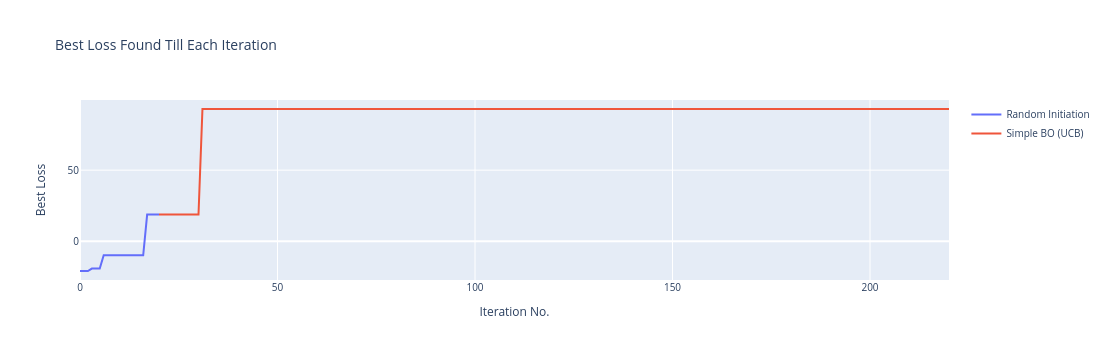

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set+1), y=optimizer.history['Y'][:init_set+1], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set, len(optimizer.history['Y'])), y=optimizer.history['Y'][init_set:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Best Loss",
    title="Best Loss Found Till Each Iteration",
    font=dict(size=10)
)

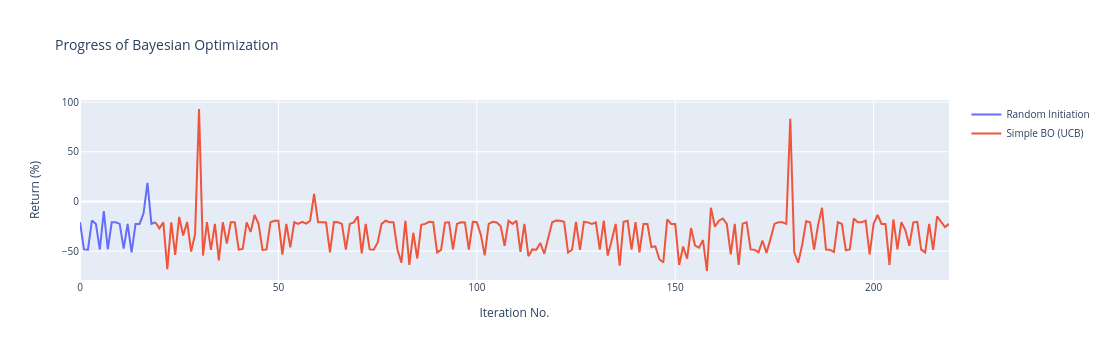

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set), y=optimizer.Y.flatten()[:init_set], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set-1, optimizer.Y.flatten().shape[-1]), y=optimizer.Y.flatten()[init_set-1:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Return (%)",
    title="Progress of Bayesian Optimization",
    font=dict(size=10),
)

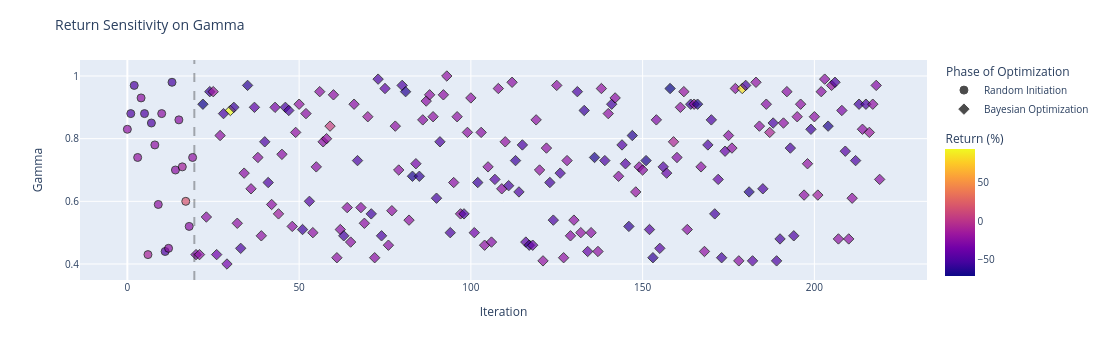

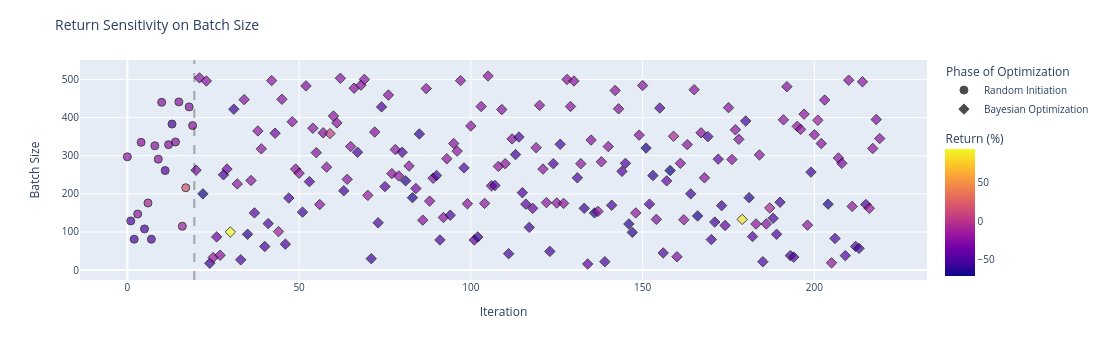

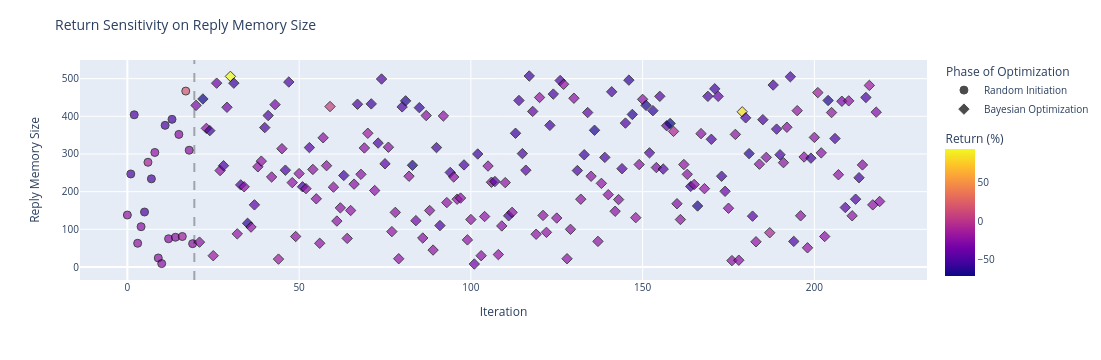

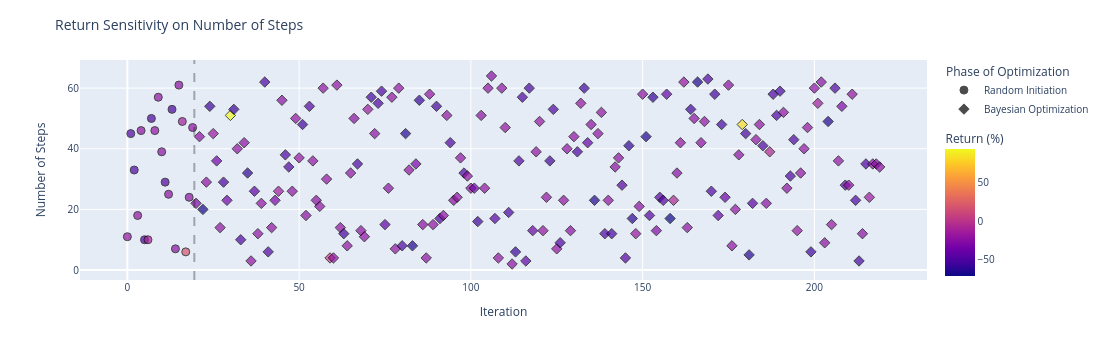

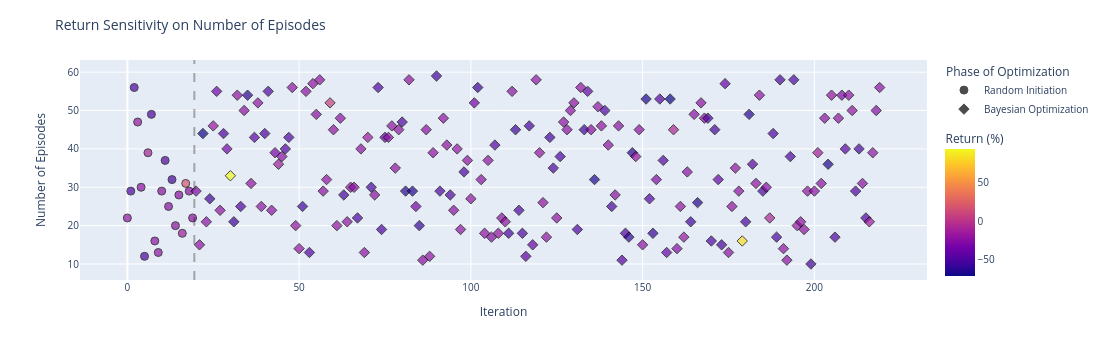

In [6]:
import numpy as np
import plotly.express as px

params = ['Gamma', 'Batch Size', 'Reply Memory Size', 'Number of Steps', 'Number of Episodes']

for index, param in enumerate(params):
    # Your existing data
    x = np.arange(len(optimizer.Y.flatten()))
    y = optimizer.X[:, index]
    returns = optimizer.Y.flatten()
    
    # Map labels to symbols
    symbols = np.array(['Random Initiation' if i < init_set else 'Bayesian Optimization' for i in range(len(x))])
    
    # Create the scatter plot with returns as color and symbols for 'Train' and 'Test'
    fig = px.scatter(
        x=x,
        y=y,
        color=returns,
        symbol=symbols,  # Use symbols here
        # labels={"x": "Iteration", "y": "Log2 of Batch Size"},
        # title="Return Sensitivity on Batch Size"
    )
    
    # Update plot layout
    fig.update_layout(title=f'Return Sensitivity on {param}',
        xaxis_title='Iteration',
        yaxis_title=f'{param}',
        legend_title="Phase of Optimization",
        font=dict(size=10))
    
    # Update trace properties
    fig.update_traces(marker=dict(
        size=8,
        opacity=0.7,
        line=dict(
            color='black',
            width=1
        )
    ))
    
    # Update color axis
    fig.update_layout(coloraxis_colorbar=dict(
        title="Return (%)",
        x=1.01,  # Adjust the position
        y=0.35,
        lenmode='fraction',
        len=0.75
    ))
    
    # Add annotations for 'Train' and 'Test'
    # fig.add_annotation(
    #     x=init_set - 0.15 * max(x) , y=max(y)*1.1, text="Random Initiation", showarrow=False, yshift=10
    # )
    # fig.add_annotation(
    #     x=init_set + 0.1 * max(x), y=max(y)*1.1, text="Bayesian Optimization", showarrow=False, yshift=10
    # )
    
    # Add a vertical line to separate 'Train' and 'Test'
    fig.add_vline(x=init_set - 0.5, line_width=2, line_dash="dash", line_color="black", opacity=0.3)
    
    # Show the plot
    fig.show()

In [7]:
set_random_seed(42)

In [8]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Simple BO (EI)',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    # optimizer = load_pkl('run/Simple BO/DQN-pattern/optimizer.pkl')

    optimizer = SimpleBayesianOptimizer(objective_func, bounds, types, name='Simple BO (EI)')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set, acquisition_func='EI')

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:12<00:00,  1.77it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [04:29<00:00,  9.28s/it]


Complete
tensor([  0.9661,  81.0000, 404.0000,  33.0000,  56.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 56/56 [07:23<00:00,  7.92s/it]


Complete
tensor([  0.7434, 147.0000,  63.0000,  18.0000,  47.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 47/47 [00:30<00:00,  1.53it/s]


Complete
tensor([  0.9297, 335.0000, 107.0000,  46.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 30/30 [00:14<00:00,  2.02it/s]


Complete
tensor([  0.8842, 108.0000, 146.0000,  10.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 12/12 [01:39<00:00,  8.27s/it]


Complete
tensor([  0.4334, 176.0000, 278.0000,  10.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 39/39 [06:56<00:00, 10.67s/it]


Complete
tensor([  0.8473,  81.0000, 234.0000,  50.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 49/49 [06:57<00:00,  8.53s/it]


Complete
tensor([  0.7818, 326.0000, 304.0000,  46.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


Complete
tensor([  0.5895, 291.0000,  24.0000,  57.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 13/13 [00:08<00:00,  1.52it/s]


Complete
tensor([  0.8772, 440.0000,   9.0000,  39.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


Complete
tensor([  0.4421, 261.0000, 376.0000,  29.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 37/37 [07:43<00:00, 12.54s/it]


Complete
tensor([  0.4468, 329.0000,  75.0000,  25.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 25/25 [00:14<00:00,  1.78it/s]


Complete
tensor([  0.9766, 383.0000, 392.0000,  53.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 32/32 [07:50<00:00, 14.72s/it]


Complete
tensor([  0.7007, 336.0000,  79.0000,   7.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]


Complete
tensor([  0.8550, 441.0000, 352.0000,  61.0000,  28.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 28/28 [00:22<00:00,  1.22it/s]


Complete
tensor([  0.7107, 115.0000,  81.0000,  49.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]


Complete
tensor([  0.5957, 216.0000, 467.0000,   6.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 31/31 [05:55<00:00, 11.46s/it]


Complete
tensor([  0.5185, 428.0000, 310.0000,  24.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


Complete
tensor([  0.7387, 379.0000,  62.0000,  47.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:20<00:00,  1.06it/s]


Complete
tensor([0.])


0it [00:00, ?it/s]

tensor([  0.5316, 387.9636, 463.2059,  31.3762,  15.3192])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [03:44<00:00, 14.99s/it]


Complete


1it [03:50, 230.34s/it]

tensor([  0.4682, 102.0392,  89.1481,  51.8594,  13.6180])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s]


Complete


2it [04:01, 101.27s/it]

tensor([  0.5211, 252.6971,  73.5580,  46.6873,  57.6511])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:35<00:00,  1.62it/s]


Complete


3it [04:39, 72.41s/it] 

tensor([  0.8223, 166.2493, 484.3513,  31.0127,  11.8875])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [02:03<00:00, 10.27s/it]


Complete


4it [06:46, 94.17s/it]

tensor([  0.8904, 134.4067, 285.2238,  25.7774,  11.3483])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [01:42<00:00,  9.35s/it]


Complete


5it [08:32, 98.37s/it]

tensor([  0.5335, 404.4417, 279.1399,  27.1480,  52.4053])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:33<00:00,  1.58it/s]


Complete


6it [09:09, 77.45s/it]

tensor([  0.8120, 281.3882, 431.9142,   9.9488,  29.3915])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [06:22<00:00, 13.19s/it]


Complete


7it [15:35, 178.28s/it]

tensor([  0.5490, 368.9542,  65.4578,  10.0978,  35.9364])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:30<00:00,  1.20it/s]


Complete


8it [16:08, 131.91s/it]

tensor([  0.5797, 327.7648, 173.6683,  32.7138,  12.2008])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:08<00:00,  1.47it/s]


Complete


9it [16:18, 94.02s/it] 

tensor([  0.8595, 288.3904, 358.3711,   3.4389,  10.3408])
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [02:06<00:00, 12.65s/it]


Complete


10it [18:28, 104.95s/it]

tensor([  0.6494,  23.0754, 286.6759,  36.6963,  35.5634])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [03:55<00:00,  6.54s/it]


Complete


11it [22:26, 145.88s/it]

tensor([  0.8744, 489.4612, 461.5026,  22.6299,  27.7154])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:17<00:00,  1.61it/s]


Complete


12it [22:46, 107.56s/it]

tensor([  0.7036, 180.8680, 125.2563,   4.2787,  11.4478])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.33it/s]


Complete


13it [22:57, 78.22s/it] 

tensor([  0.9172, 323.8704,  73.6698,  55.2021,  53.4713])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [00:35<00:00,  1.50it/s]


Complete


14it [23:35, 65.95s/it]

tensor([ 0.7484, 23.8205, 87.7900, 17.7641, 47.5236])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [05:22<00:00,  6.72s/it]


Complete


15it [29:00, 144.16s/it]

tensor([  0.6794,  75.0665, 217.6832,  22.6901,  23.1123])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [03:10<00:00,  8.28s/it]


Complete


16it [32:15, 159.61s/it]

tensor([  0.6246, 314.4997, 293.4464,  49.8450,  12.6890])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  1.86it/s]


Complete


17it [32:25, 114.47s/it]

tensor([  0.4086, 163.2560, 291.5616,  10.9735,  19.9472])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [03:26<00:00, 10.33s/it]


Complete


18it [35:54, 143.03s/it]

tensor([  0.5124, 498.7802, 249.4604,  18.4745,  57.3729])
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [00:40<00:00,  1.41it/s]


Complete


19it [36:37, 112.97s/it]

tensor([  0.7373, 326.8231, 382.2550,  39.3745,  37.5332])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [08:48<00:00, 13.91s/it]


Complete


20it [45:29, 238.56s/it]

tensor([  0.4725, 350.1724, 191.3126,  34.6606,  12.3925])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.63it/s]


Complete


21it [45:39, 169.92s/it]

tensor([  0.7544, 333.3281, 269.5083,  38.3941,  49.2962])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


Complete


22it [46:18, 130.67s/it]

tensor([  0.6610, 371.3322,  88.0279,  33.2938,  13.3781])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


Complete


23it [46:28, 94.55s/it] 

tensor([  0.9186, 213.3583, 218.5858,   5.1948,  40.7912])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [07:57<00:00, 11.64s/it]


Complete


24it [54:28, 210.22s/it]

tensor([  0.6835, 115.1756, 237.5943,  27.6229,  12.4625])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [01:44<00:00,  8.69s/it]


Complete


25it [56:16, 179.40s/it]

tensor([  0.9334, 239.5361,  45.6899,  48.9984,  41.3158])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:30<00:00,  1.34it/s]


Complete


26it [56:49, 135.56s/it]

tensor([  0.8060,  48.7924, 279.2128,  14.8664,  58.7200])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [07:34<00:00,  7.70s/it]


Complete


27it [1:04:26, 232.03s/it]

tensor([  0.7837, 268.3216, 478.5903,  25.0245,  41.8075])
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [08:46<00:00, 12.53s/it]


Complete


28it [1:13:15, 321.12s/it]

tensor([  0.5134, 127.4674, 450.3581,  10.9943,  44.8792])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [06:49<00:00,  9.09s/it]


Complete


29it [1:20:07, 348.44s/it]

tensor([  0.5121, 478.8688, 293.9811,  31.9841,  39.8826])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]


Complete


30it [1:20:36, 252.47s/it]

tensor([  0.6411, 170.0308,  21.6645,   6.0403,  40.6182])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:28<00:00,  1.44it/s]


Complete


31it [1:21:07, 186.17s/it]

tensor([  0.9721, 491.5116,  87.8738,  56.4129,  29.8780])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [00:17<00:00,  1.73it/s]


Complete


32it [1:21:27, 136.41s/it]

tensor([  0.9141, 384.8525, 223.8032,  53.0887,  27.3593])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:15<00:00,  1.70it/s]


Complete


33it [1:21:46, 101.01s/it]

tensor([  0.6607, 118.2216, 176.7552,   3.8941,  33.1014])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [05:03<00:00,  9.19s/it]


Complete


34it [1:26:52, 162.48s/it]

tensor([  0.6417, 314.5938, 393.3505,   6.3341,  52.0777])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [11:48<00:00, 13.63s/it]


Complete


35it [1:38:45, 327.74s/it]

tensor([  0.4140, 126.5710, 245.5835,   2.4271,  45.6561])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [07:06<00:00,  9.26s/it]


Complete


36it [1:45:55, 358.50s/it]

tensor([  0.5574, 306.2621, 408.5532,  37.5479,  59.4142])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [13:02<00:00, 13.26s/it]


Complete


37it [1:59:02, 487.08s/it]

tensor([  0.5522, 312.1582, 231.6276,  49.0050,  11.0612])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:11<00:00,  1.08s/it]


Complete


38it [1:59:18, 345.54s/it]

tensor([  0.4734, 238.6176, 204.8164,  53.1892,  21.2713])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:13<00:00,  1.54it/s]


Complete


39it [1:59:34, 246.88s/it]

tensor([  0.9099, 310.2607, 122.7587,  23.6440,  16.2572])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Complete


40it [1:59:47, 176.47s/it]

tensor([  0.8789, 246.3282, 135.3228,  57.9681,  40.8527])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:28<00:00,  1.43it/s]


Complete


41it [2:00:18, 132.82s/it]

tensor([  0.4985, 208.0098, 157.6720,  59.7190,  37.6393])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:23<00:00,  1.60it/s]


Complete


42it [2:00:44, 100.80s/it]

tensor([  0.6121, 305.7725, 247.9988,  19.6171,  31.2953])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.27it/s]


Complete


43it [2:01:13, 79.24s/it] 

tensor([  0.7292, 473.3661, 374.4759,  63.0678,  26.9328])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:16<00:00,  1.66it/s]


Complete


44it [2:01:33, 61.46s/it]

tensor([  0.4979, 360.4362, 445.9089,  33.8953,  22.5998])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [05:28<00:00, 14.27s/it]


Complete


45it [2:07:07, 143.19s/it]

tensor([  0.6726, 455.7600, 423.7226,  36.9532,  17.4494])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:11<00:00,  1.51it/s]


Complete


46it [2:07:22, 104.82s/it]

tensor([  0.5182, 371.3571, 341.2562,  38.6782,  20.5405])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.49it/s]


Complete


47it [2:07:40, 78.81s/it] 

tensor([  0.7146, 336.1127, 358.4828,   8.9227,  59.8251])
Training DeepRL ...



100%|███████████████████████████████████████████| 60/60 [13:58<00:00, 13.98s/it]


Complete


48it [2:21:43, 308.10s/it]

tensor([  0.7190,  68.1631, 234.5938,  20.9701,  46.3213])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [05:45<00:00,  7.51s/it]


Complete


49it [2:27:32, 320.50s/it]

tensor([  0.9502, 378.6047, 187.7360,  48.9070,  55.4805])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:37<00:00,  1.47it/s]


Complete


50it [2:28:13, 236.37s/it]

tensor([  0.8053, 268.1591, 165.6936,  35.4473,  23.3015])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [00:14<00:00,  1.56it/s]


Complete


51it [2:28:30, 170.78s/it]

tensor([  0.9841, 224.3362, 405.9461,  10.6911,  38.5371])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [07:28<00:00, 11.50s/it]


Complete


52it [2:36:02, 254.99s/it]

tensor([ 0.5745, 43.3317, 11.5291, 54.2381, 35.1736])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:22<00:00,  1.53it/s]


Complete


53it [2:36:27, 186.22s/it]

tensor([  0.6504,  68.6894, 205.0483,  13.8800,  39.1219])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [05:02<00:00,  7.75s/it]


Complete


54it [2:41:35, 222.65s/it]

tensor([  0.9037, 150.3699, 427.9980,  23.1843,  25.6896])
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [04:27<00:00, 10.28s/it]


Complete


55it [2:46:06, 236.98s/it]

tensor([  0.4754, 291.7782, 148.2386,  36.8336,  50.7886])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:33<00:00,  1.53it/s]


Complete


56it [2:46:42, 176.77s/it]

tensor([  0.9907, 329.5923, 203.2326,  11.7931,  27.6101])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:19<00:00,  1.41it/s]


Complete


57it [2:47:04, 130.54s/it]

tensor([4.9581e-01, 4.9766e+02, 2.8367e+02, 5.0924e+01, 1.2155e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.74it/s]


Complete


58it [2:47:14, 94.15s/it] 

tensor([  0.8372, 348.9381, 477.1749,  51.6942,  58.4125])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [13:39<00:00, 14.13s/it]


Complete


59it [3:00:56, 312.63s/it]

tensor([  0.9330,  46.4873, 352.9810,   5.6474,  18.9699])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [02:18<00:00,  7.30s/it]


Complete


60it [3:03:18, 261.42s/it]

tensor([  0.8343,  51.5413, 353.6000,  58.4353,  24.8569])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [03:09<00:00,  7.60s/it]


Complete


61it [3:06:31, 240.95s/it]

tensor([  0.7910, 210.5104, 257.3296,  41.0846,  58.9985])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [10:38<00:00, 10.83s/it]


Complete


62it [3:17:14, 361.61s/it]

tensor([  0.5380, 109.1938, 393.3082,  40.0494,  10.9426])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [01:35<00:00,  8.69s/it]


Complete


63it [3:18:56, 283.60s/it]

tensor([  0.4120, 289.7811,  11.5954,  28.8478,  35.5747])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:22<00:00,  1.59it/s]


Complete


64it [3:19:21, 206.11s/it]

tensor([  0.4378, 274.1705, 115.5666,  44.5773,  33.0664])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [00:18<00:00,  1.76it/s]


Complete


65it [3:19:43, 150.64s/it]

tensor([  0.8256, 481.4854, 306.5522,  58.6514,  37.5622])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:21<00:00,  1.80it/s]


Complete


66it [3:20:06, 112.59s/it]

tensor([  0.7274, 464.9089, 441.2727,  62.9273,  37.4328])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [00:25<00:00,  1.42it/s]


Complete


67it [3:20:35, 87.32s/it] 

tensor([  0.8536, 158.7129, 351.3123,  23.9375,  17.3335])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:51<00:00, 10.07s/it]


Complete


68it [3:23:29, 113.30s/it]

tensor([  0.5658, 190.5455,  38.4272,  18.9562,  54.6583])
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:33<00:00,  1.63it/s]


Complete


69it [3:24:05, 90.22s/it] 

tensor([  0.8348, 300.2083,  93.9866,  41.1231,  11.3565])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.58it/s]


Complete


70it [3:24:14, 66.00s/it]

tensor([  0.6133, 421.7948, 474.0833,  11.4309,  29.1997])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [07:36<00:00, 15.74s/it]


Complete


71it [3:31:54, 184.03s/it]

tensor([  0.7244,  71.4016, 507.9696,  48.4719,  19.6894])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [02:30<00:00,  7.54s/it]


Complete


72it [3:34:28, 174.94s/it]

tensor([  0.8304,  56.4372, 195.7467,  15.9147,  17.3324])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [02:04<00:00,  7.35s/it]


Complete


73it [3:36:38, 161.45s/it]

tensor([4.2126e-01, 4.9137e+02, 2.5525e+02, 6.2359e+01, 5.0763e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:37<00:00,  1.37it/s]


Complete


74it [3:37:19, 125.59s/it]

tensor([  0.7986, 230.3553, 205.5874,  17.4892,  38.1893])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:24<00:00,  1.56it/s]


Complete


75it [3:37:48, 96.38s/it] 

tensor([  0.4940, 479.2459, 126.9784,  57.5021,  20.7031])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:12<00:00,  1.71it/s]


Complete


76it [3:38:03, 71.97s/it]

tensor([  0.4096, 161.3294, 380.2036,  52.7934,  19.1353])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [03:05<00:00,  9.79s/it]


Complete


77it [3:41:12, 107.07s/it]

tensor([  0.4988, 244.7445, 143.3937,  55.2977,  29.1367])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


Complete


78it [3:41:37, 82.55s/it] 

tensor([  0.5144,  80.5751, 142.0405,  34.2814,  51.7171])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [07:00<00:00,  8.09s/it]


Complete


79it [3:48:41, 185.03s/it]

tensor([  0.5486, 467.4025, 352.0446,  44.9597,  12.0766])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.09it/s]


Complete


80it [3:48:55, 133.81s/it]

tensor([  0.6930, 465.9128, 386.9093,   7.5919,  35.0390])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:21<00:00,  1.59it/s]


Complete


81it [3:49:20, 101.01s/it]

tensor([  0.8380, 304.3863,  54.1354,  57.7032,  51.9556])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:33<00:00,  1.53it/s]


Complete


82it [3:49:57, 81.69s/it] 

tensor([  0.7925, 338.7570, 183.5498,  51.3433,  25.2525])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:15<00:00,  1.66it/s]


Complete


83it [3:50:16, 62.97s/it]

tensor([  0.8133, 310.7424, 408.8908,  13.4597,  45.9969])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [10:21<00:00, 13.51s/it]


Complete


84it [4:00:41, 231.57s/it]

tensor([  0.8399, 231.7843, 311.1855,  49.2134,  53.2831])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [10:04<00:00, 11.41s/it]


Complete


85it [4:10:50, 344.89s/it]

tensor([  0.9386, 136.1814, 258.5679,  52.9334,  17.8704])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [02:55<00:00,  9.72s/it]


Complete


86it [4:13:49, 295.15s/it]

tensor([  0.9231, 107.5999, 117.7982,  24.1480,  26.0750])
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [03:45<00:00,  8.66s/it]


Complete


87it [4:17:37, 275.02s/it]

tensor([  0.7507, 359.4379, 469.8989,  16.9933,  12.6037])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [03:11<00:00, 14.73s/it]


Complete


88it [4:20:51, 250.75s/it]

tensor([ 0.4608, 76.9145, 88.5302, 32.9577, 20.6621])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [02:59<00:00,  8.55s/it]


Complete


89it [4:23:54, 230.32s/it]

tensor([  0.7980, 139.3539, 218.3520,  17.5005,  59.5494])
Training DeepRL ...



100%|███████████████████████████████████████████| 60/60 [09:28<00:00,  9.48s/it]


Complete


90it [4:33:26, 332.85s/it]

tensor([  0.8170, 362.2500, 468.6620,  47.0424,  52.1990])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [12:33<00:00, 14.49s/it]


Complete


91it [4:46:04, 460.39s/it]

tensor([  0.6223, 225.7224, 510.9818,  16.9659,  40.5313])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [07:42<00:00, 11.27s/it]


Complete


92it [4:53:56, 463.90s/it]

tensor([  0.7900, 278.4619, 507.2207,  45.4394,  30.6926])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [06:48<00:00, 13.16s/it]


Complete


93it [5:00:49, 448.52s/it]

tensor([  0.9907, 467.0719, 306.7825,  36.1813,  19.8860])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Complete


94it [5:01:04, 318.43s/it]

tensor([  0.7744,  74.6735, 306.9824,  63.9889,  10.1036])
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [01:20<00:00,  8.02s/it]


Complete


95it [5:02:28, 248.09s/it]

tensor([  0.7867,  49.1718, 438.3476,  34.9979,  21.9238])
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [02:34<00:00,  7.02s/it]


Complete


96it [5:05:07, 221.32s/it]

tensor([  0.4658, 339.4347, 324.7064,  38.6187,  38.9273])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:23<00:00,  1.66it/s]


Complete


97it [5:05:33, 162.91s/it]

tensor([  0.6076, 470.8678, 367.5297,  44.4887,  38.8016])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:21<00:00,  1.82it/s]


Complete


98it [5:05:57, 121.23s/it]

tensor([4.8942e-01, 1.3759e+02, 5.0038e+02, 2.1605e+01, 2.0044e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [03:11<00:00,  9.59s/it]


Complete


99it [5:09:12, 143.38s/it]

tensor([  0.6948, 287.2743, 440.3749,  52.7362,  37.0186])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [07:59<00:00, 12.97s/it]


Complete


100it [5:17:19, 246.26s/it]

tensor([  0.9627, 121.5488, 499.8721,  23.9453,  43.0174])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [06:22<00:00,  8.90s/it]


Complete


101it [5:23:50, 289.70s/it]

tensor([  0.7277,  15.8040, 274.8005,  59.7598,  30.6223])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [03:29<00:00,  6.77s/it]


Complete


102it [5:27:23, 266.80s/it]

tensor([  0.9151,  77.4998, 464.5811,  42.5732,  39.9696])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [05:31<00:00,  8.29s/it]


Complete


103it [5:32:58, 287.35s/it]

tensor([  0.5136, 490.5945, 478.8606,  41.2968,  48.7384])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


Complete


104it [5:33:33, 211.57s/it]

tensor([  0.7443, 246.1314, 272.5319,  42.0922,  13.3809])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [02:36<00:00, 12.06s/it]


Complete


105it [5:36:13, 196.18s/it]

tensor([  0.6540, 320.6618, 263.7579,  14.7457,  51.7221])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Complete


106it [5:36:54, 149.57s/it]

tensor([  0.8614, 232.0258, 180.0892,  33.1753,  23.7970])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [00:17<00:00,  1.34it/s]


Complete


107it [5:37:15, 110.86s/it]

tensor([  0.7064, 451.9675, 417.5901,  49.7733,  45.1720])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:25<00:00,  1.74it/s]


Complete


108it [5:37:43, 86.05s/it] 

tensor([  0.5381,  79.3703, 483.6189,   6.1000,  12.7399])
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [01:44<00:00,  8.01s/it]


Complete


109it [5:39:30, 92.42s/it]

tensor([ 0.4189, 90.1547, 53.4634, 53.8039, 33.3386])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [00:19<00:00,  1.71it/s]


Complete


110it [5:39:56, 72.58s/it]

tensor([  0.4451, 140.9666, 256.9791,   2.1184,  33.3055])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [05:32<00:00, 10.07s/it]


Complete


111it [5:45:33, 151.67s/it]

tensor([  0.7156, 419.6356, 165.3380,  26.1735,  39.9365])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]


Complete


112it [5:46:03, 115.18s/it]

tensor([  0.8520,  67.5860, 242.2547,   8.0209,  48.9820])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [06:32<00:00,  8.02s/it]


Complete


113it [5:52:39, 199.66s/it]

tensor([  0.9036, 112.0151, 457.8059,  20.2966,  49.6286])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [07:23<00:00,  8.87s/it]


Complete


114it [6:00:06, 273.81s/it]

tensor([  0.9312,  18.9864, 301.7622,  11.4723,  24.6722])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [03:06<00:00,  7.47s/it]


Complete


115it [6:03:17, 248.75s/it]

tensor([  0.9119,  90.7370, 328.2819,  38.1841,  31.2162])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [04:21<00:00,  8.43s/it]


Complete


116it [6:07:41, 253.48s/it]

tensor([  0.6469, 145.6581, 415.8518,  50.3199,  52.7411])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [08:35<00:00,  9.73s/it]


Complete


117it [6:16:21, 333.37s/it]

tensor([  0.6940, 169.3767, 154.9307,  51.7032,  24.7836])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.52it/s]


Complete


118it [6:16:40, 239.21s/it]

tensor([  0.4876, 430.9675,  24.5597,  50.8716,  17.9117])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s]


Complete


119it [6:17:01, 173.57s/it]

tensor([  0.8536, 149.2013, 186.1296,  61.4701,  18.2316])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [02:54<00:00,  9.67s/it]


Complete


120it [6:19:58, 174.74s/it]

tensor([  0.4045, 205.4444, 216.4057,  49.4885,  51.2659])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [09:29<00:00, 11.17s/it]


Complete


121it [6:29:31, 294.29s/it]

tensor([  0.7038, 210.6259, 183.2856,  46.4438,  27.6585])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:23<00:00,  1.21it/s]


Complete


122it [6:29:58, 213.84s/it]

tensor([4.3750e-01, 5.1136e+02, 1.8797e+02, 6.3878e+01, 5.8623e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [00:39<00:00,  1.50it/s]


Complete


123it [6:30:40, 162.33s/it]

tensor([  0.5240, 391.8775, 289.7137,  40.4627,  17.9506])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]


Complete


124it [6:30:53, 117.65s/it]

tensor([  0.7100, 316.0116,  70.5878,  20.6439,  11.5828])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.62it/s]


Complete


125it [6:31:03, 85.30s/it] 

tensor([  0.7228, 433.7787,  37.6496,  34.5554,  26.7481])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:19<00:00,  1.42it/s]


Complete


126it [6:31:25, 66.22s/it]

tensor([  0.7247, 262.5403, 219.4835,  38.4676,  27.1823])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:17<00:00,  1.50it/s]


Complete


127it [6:31:47, 52.94s/it]

tensor([  0.9500, 181.0077, 498.7812,   3.7308,  19.1348])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [03:16<00:00, 10.33s/it]


Complete


128it [6:35:06, 96.98s/it]

tensor([  0.5227, 147.2806, 408.8186,  60.2086,  34.2976])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [05:30<00:00,  9.71s/it]


Complete


129it [6:40:47, 170.02s/it]

tensor([  0.4926, 104.3899, 200.4047,  40.5758,  15.7901])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [02:10<00:00,  8.19s/it]


Complete


130it [6:43:01, 159.25s/it]

tensor([  0.6331, 175.1205, 487.1156,  49.4893,  57.7179])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [09:59<00:00, 10.33s/it]


Complete


131it [6:53:04, 292.47s/it]

tensor([  0.6528, 511.4315, 428.8452,  50.7904,  44.5386])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:26<00:00,  1.69it/s]


Complete


132it [6:53:34, 213.77s/it]

tensor([  0.9818, 280.1302,  48.8820,  60.6060,  47.5634])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:31<00:00,  1.51it/s]


Complete


133it [6:54:09, 160.07s/it]

tensor([  0.8888,  56.4784, 497.4995,  49.4093,  52.5030])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [06:40<00:00,  7.56s/it]


Complete


134it [7:00:55, 233.74s/it]

tensor([  0.7493, 399.8455,  57.8339,  62.9702,  41.0170])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:24<00:00,  1.65it/s]


Complete


135it [7:01:22, 171.92s/it]

tensor([  0.5119,  25.5781, 510.4042,   7.1757,  29.6350])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [03:30<00:00,  7.00s/it]


Complete


136it [7:04:56, 184.51s/it]

tensor([  0.7641, 271.3600, 396.9776,  16.1067,  52.3830])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [11:18<00:00, 13.04s/it]


Complete


137it [7:16:20, 334.32s/it]

tensor([  0.9837,  66.4603, 473.2945,  43.6324,  46.1448])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [05:54<00:00,  7.71s/it]


Complete


138it [7:22:23, 342.73s/it]

tensor([  0.9104, 484.9867, 191.3820,   5.6052,  43.3043])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:31<00:00,  1.37it/s]


Complete


139it [7:22:57, 250.33s/it]

tensor([  0.8433, 506.9623, 210.7146,  35.0217,  19.0503])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [00:12<00:00,  1.58it/s]


Complete


140it [7:23:12, 179.76s/it]

tensor([  0.4582, 212.9546, 412.4903,  44.2807,  34.3680])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [06:14<00:00, 11.01s/it]


Complete


141it [7:29:32, 239.68s/it]

tensor([  0.5736, 376.5557, 272.9606,  44.8544,  42.3607])
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.56it/s]


Complete


142it [7:30:03, 177.17s/it]

tensor([  0.6882, 267.1918, 424.2645,  14.5891,  51.4952])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [10:28<00:00, 12.33s/it]


Complete


143it [7:40:35, 313.63s/it]

tensor([ 0.9015, 24.5384, 91.3770,  3.3679, 15.1175])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [01:44<00:00,  6.96s/it]


Complete


144it [7:42:23, 252.03s/it]

tensor([  0.7980, 153.8028,  11.9602,   7.0230,  10.4600])
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Complete


145it [7:42:33, 179.21s/it]

tensor([  0.6688, 335.7319, 400.5867,  25.0563,  52.8336])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [12:20<00:00, 13.98s/it]


Complete


146it [7:54:58, 349.10s/it]

tensor([ 0.9809, 66.1353, 42.8823,  2.3881, 56.3132])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [00:37<00:00,  1.48it/s]


Complete


147it [7:55:41, 257.19s/it]

tensor([  0.8204, 446.1012,  83.4228,  30.4079,  19.5305])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Complete


148it [7:55:59, 185.29s/it]

tensor([  0.4413, 103.2896,  10.5114,  57.2418,  24.1318])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [00:16<00:00,  1.49it/s]


Complete


149it [7:56:18, 135.45s/it]

tensor([  0.8977, 495.8218, 363.2363,  16.3182,  30.9001])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:27<00:00,  1.15it/s]


Complete


150it [7:56:48, 103.96s/it]

tensor([  0.7241, 432.2067, 257.5894,  39.7337,  48.3291])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Complete


151it [7:57:26, 84.11s/it] 

tensor([  0.6666, 206.0144, 354.3227,  19.3247,  16.6169])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [03:11<00:00, 11.29s/it]


Complete


152it [8:00:41, 117.32s/it]

tensor([  0.8419, 110.1852, 261.3839,  35.7587,  11.6004])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [01:47<00:00,  8.93s/it]


Complete


153it [8:02:32, 115.51s/it]

tensor([  0.6243, 435.1343, 464.8908,  23.9060,  23.7457])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [06:22<00:00, 15.93s/it]


Complete


154it [8:08:59, 196.99s/it]

tensor([  0.4031, 281.5553, 172.5563,  24.2066,  24.6073])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.37it/s]


Complete


155it [8:09:23, 145.00s/it]

tensor([  0.7411,  35.2138, 371.8155,  15.5809,  50.6146])
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [06:17<00:00,  7.41s/it]


Complete


156it [8:15:45, 216.00s/it]

tensor([  0.8652,  72.6584, 115.9108,  58.2639,  28.1176])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [03:49<00:00,  8.19s/it]


Complete


157it [8:19:41, 222.25s/it]

tensor([  0.6825, 332.0213, 174.7439,  27.6616,  35.6349])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:27<00:00,  1.33it/s]


Complete


158it [8:20:13, 164.97s/it]

tensor([  0.5655, 436.8943, 357.5167,  56.3226,  38.8731])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:24<00:00,  1.58it/s]


Complete


159it [8:20:40, 123.81s/it]

tensor([  0.7047, 160.0741, 229.8789,  56.0687,  22.9385])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [03:50<00:00, 10.03s/it]


Complete


160it [8:24:35, 156.91s/it]

tensor([  0.6123, 427.5157, 463.9737,  21.1345,  45.3140])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [12:25<00:00, 16.57s/it]


Complete


161it [8:37:05, 335.01s/it]

tensor([  0.9188, 490.5883, 177.6680,  22.8961,  10.5865])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.70it/s]


Complete


162it [8:37:17, 238.06s/it]

tensor([  0.6169, 176.6421, 333.1919,  15.1011,  45.9434])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [07:53<00:00, 10.29s/it]


Complete


163it [8:45:18, 310.86s/it]

tensor([  0.5759, 360.0840, 285.1513,  35.1400,  49.1893])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


Complete


164it [8:45:56, 229.11s/it]

tensor([  0.7318, 367.7220, 420.5278,  27.2134,  38.2579])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [09:19<00:00, 14.73s/it]


Complete


165it [8:55:23, 330.47s/it]

tensor([  0.4110, 184.1216, 177.4505,   6.5245,  20.0841])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Complete


166it [8:55:41, 236.58s/it]

tensor([  0.7357, 193.2556, 362.4859,  15.8593,  56.3162])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [10:25<00:00, 11.17s/it]


Complete


167it [9:06:19, 357.12s/it]

tensor([  0.8519,  95.9703, 234.9347,  22.8934,  36.5099])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [05:22<00:00,  8.71s/it]


Complete


168it [9:11:48, 348.74s/it]

tensor([  0.7438, 231.3846, 247.4611,  57.6386,  31.5240])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [06:01<00:00, 11.31s/it]


Complete


169it [9:17:56, 354.34s/it]

tensor([  0.7683, 254.1244,  18.3291,  52.0577,  33.0912])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [00:20<00:00,  1.61it/s]


Complete


170it [9:18:20, 255.51s/it]

tensor([ 0.4721, 99.5500, 23.3307, 63.9596, 33.6635])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [00:22<00:00,  1.50it/s]


Complete


171it [9:18:46, 186.46s/it]

tensor([  0.9163, 255.0752, 290.8056,  24.9828,  11.7857])
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [02:24<00:00, 12.01s/it]


Complete


172it [9:21:13, 174.79s/it]

tensor([  0.9855, 205.6908, 134.4000,  30.9792,  47.4920])
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [00:30<00:00,  1.53it/s]


Complete


173it [9:21:48, 132.86s/it]

tensor([  0.9466, 130.6319, 283.3569,  51.7890,  40.9162])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [06:43<00:00,  9.85s/it]


Complete


174it [9:28:37, 215.65s/it]

tensor([  0.8320, 158.4636,   9.2575,  40.3227,  50.3359])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


Complete


175it [9:29:16, 162.61s/it]

tensor([  0.6875, 256.4416, 404.0744,  42.0648,  23.1541])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [04:34<00:00, 11.95s/it]


Complete


176it [9:33:55, 197.61s/it]

tensor([  0.9130, 406.0795,  81.2604,  37.8767,  13.8763])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s]


Complete


177it [9:34:15, 144.14s/it]

tensor([4.7382e-01, 5.0810e+02, 3.1788e+02, 1.5524e+01, 1.4984e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.40it/s]


Complete


178it [9:34:29, 105.09s/it]

tensor([  0.9040, 267.4751, 136.1799,  18.1655,  58.0739])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:32<00:00,  1.78it/s]


Complete


179it [9:35:05, 84.35s/it] 

tensor([  0.5866, 323.6236, 164.2577,  62.2820,  25.1384])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:24<00:00,  1.03it/s]


Complete


180it [9:35:32, 67.18s/it]

tensor([  0.8284,  68.6733, 133.3403,  12.3322,  54.2055])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [07:29<00:00,  8.33s/it]


Complete


181it [9:43:05, 182.96s/it]

tensor([  0.8418, 384.5182,  58.1181,   4.5998,  33.8731])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [00:21<00:00,  1.57it/s]


Complete


182it [9:43:30, 135.72s/it]

tensor([  0.6367, 314.6305,  13.4737,  17.4488,  25.0371])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:14<00:00,  1.68it/s]


Complete


183it [9:43:49, 100.53s/it]

tensor([  0.9045, 227.3279,  91.2777,  42.1734,  46.2780])
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:34<00:00,  1.33it/s]


Complete


184it [9:44:27, 81.70s/it] 

tensor([4.1347e-01, 2.4121e+01, 5.0948e+02, 6.0493e+01, 4.5171e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [05:19<00:00,  7.11s/it]


Complete


185it [9:49:51, 154.55s/it]

tensor([  0.7219, 211.9939,  43.2653,  27.7328,  51.8510])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:33<00:00,  1.54it/s]


Complete


186it [9:50:29, 119.49s/it]

tensor([  0.5389, 106.0501, 473.4189,  55.9058,  48.0652])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [07:03<00:00,  8.82s/it]


Complete


187it [9:57:43, 213.95s/it]

tensor([  0.4441, 152.2997, 304.6023,  54.6184,  17.9969])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [02:59<00:00,  9.95s/it]


Complete


188it [10:00:49, 205.52s/it]

tensor([  0.7022, 187.7131, 420.7786,  52.6003,  55.7037])
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [09:59<00:00, 10.71s/it]


Complete


189it [10:10:57, 326.31s/it]

tensor([  0.9950, 490.9306, 337.3600,  63.4249,  37.3928])
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [00:25<00:00,  1.46it/s]


Complete


190it [10:11:29, 238.00s/it]

tensor([  0.5692, 103.0974, 290.7228,  14.4996,  13.8862])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:04<00:00,  8.87s/it]


Complete


191it [10:13:37, 204.97s/it]

tensor([  0.9936, 199.1365, 393.0306,  43.0546,  11.0555])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [02:11<00:00, 11.92s/it]


Complete


192it [10:15:52, 183.94s/it]

tensor([  0.6319, 442.1630,  88.3418,  61.4291,  30.6168])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


Complete


193it [10:16:19, 136.80s/it]

tensor([  0.9391,  93.4347, 300.2941,   6.4522,  40.1304])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [05:41<00:00,  8.54s/it]


Complete


194it [10:22:04, 199.35s/it]

tensor([  0.5460, 152.1167, 162.9103,  57.6562,  35.6645])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [06:08<00:00, 10.24s/it]


Complete


195it [10:28:17, 251.41s/it]

tensor([  0.7018, 297.2029,  96.2351,  33.4178,  39.3839])
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:32<00:00,  1.22it/s]


Complete


196it [10:28:57, 188.05s/it]

tensor([  0.9177, 237.5101, 484.3925,   7.9856,  21.1180])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [04:04<00:00, 11.63s/it]


Complete


197it [10:33:05, 206.05s/it]

tensor([  0.8306, 150.3283, 338.5531,  63.3388,  14.1912])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:17<00:00,  9.85s/it]


Complete


198it [10:35:27, 186.91s/it]

tensor([  0.8380, 141.9216, 406.5623,  58.9600,  46.7085])
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [07:32<00:00,  9.62s/it]


Complete


199it [10:43:05, 268.10s/it]

tensor([  0.8741,  67.4277, 389.6395,  35.4630,  47.5214])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [06:26<00:00,  8.06s/it]


Complete


200it [10:49:39, 194.90s/it]


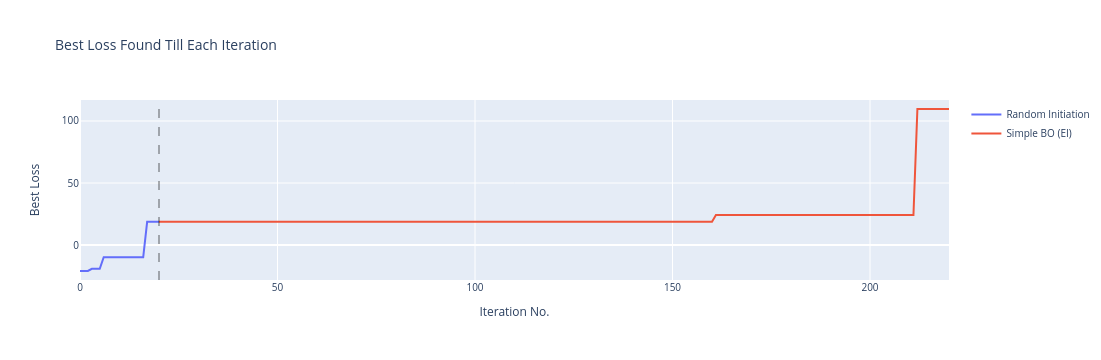

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set+1), y=optimizer.history['Y'][:init_set+1], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set, len(optimizer.history['Y'])), y=optimizer.history['Y'][init_set:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Best Loss",
    title="Best Loss Found Till Each Iteration",
    font=dict(size=10)
)
fig.add_vline(x=init_set, line_width=2, line_dash="dash", line_color="black", opacity=0.3)

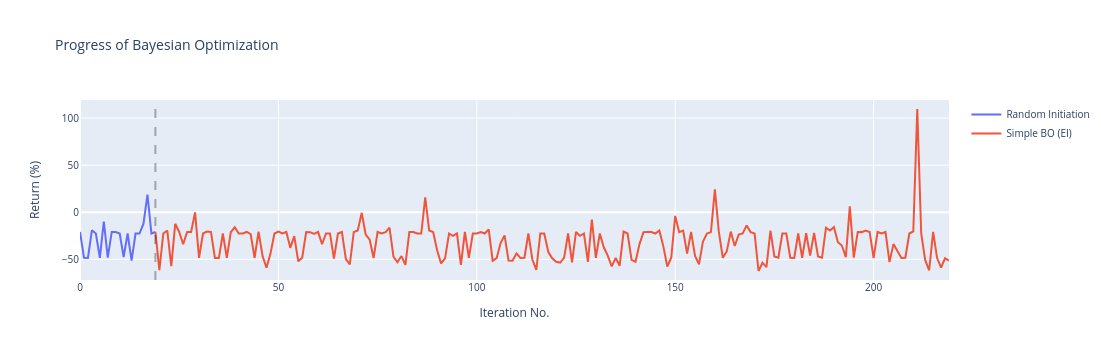

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set), y=optimizer.Y.flatten()[:init_set], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set-1, optimizer.Y.flatten().shape[-1]), y=optimizer.Y.flatten()[init_set-1:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Return (%)",
    title="Progress of Bayesian Optimization",
    font=dict(size=10),
)

fig.add_vline(x=init_set - 1, line_width=2, line_dash="dash", line_color="black", opacity=0.3)

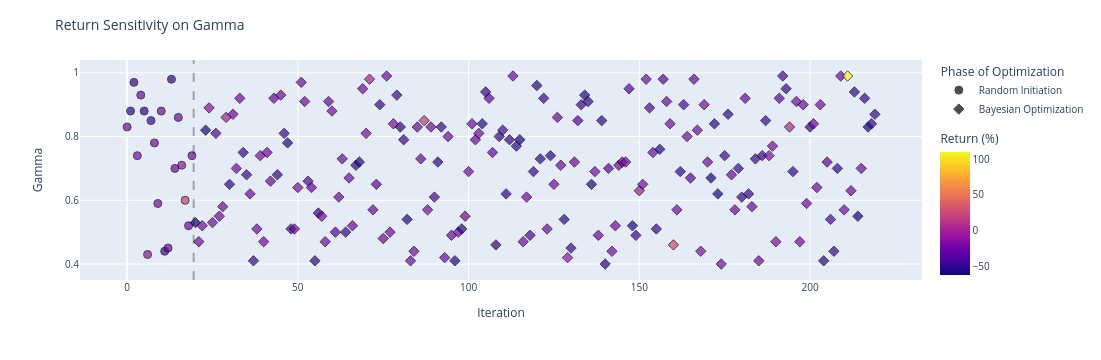

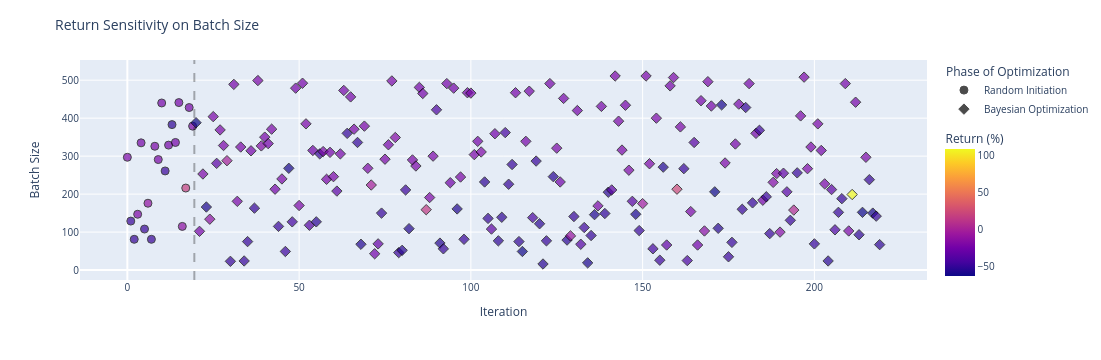

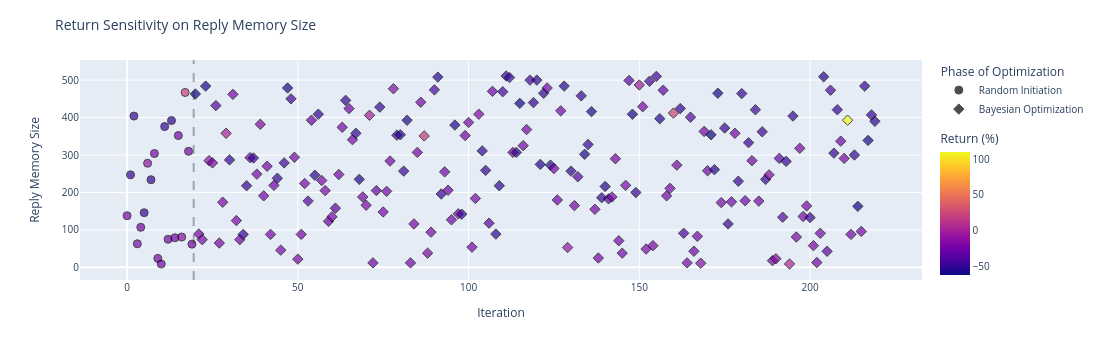

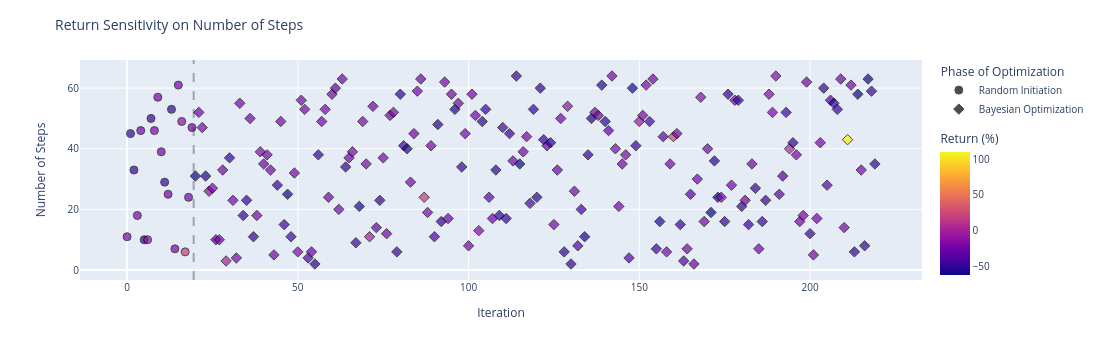

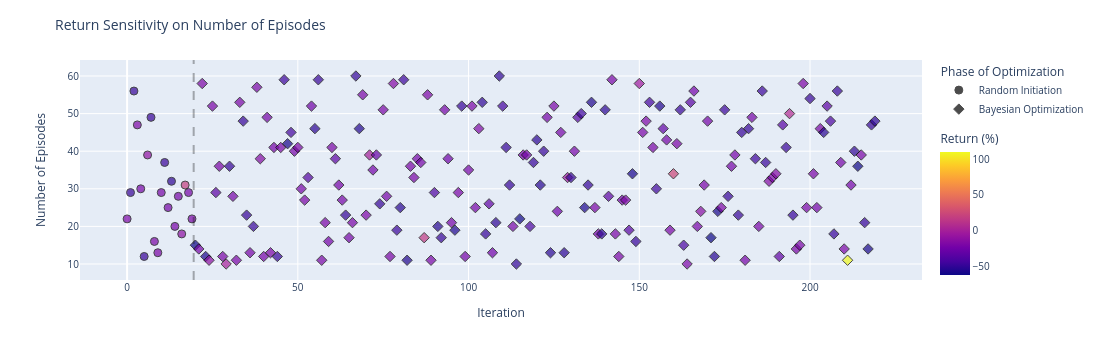

In [11]:
import numpy as np
import plotly.express as px

params = ['Gamma', 'Batch Size', 'Reply Memory Size', 'Number of Steps', 'Number of Episodes']

for index, param in enumerate(params):
    # Your existing data
    x = np.arange(len(optimizer.Y.flatten()))
    y = optimizer.X[:, index]
    returns = optimizer.Y.flatten()
    
    # Map labels to symbols
    symbols = np.array(['Random Initiation' if i < init_set else 'Bayesian Optimization' for i in range(len(x))])
    
    # Create the scatter plot with returns as color and symbols for 'Train' and 'Test'
    fig = px.scatter(
        x=x,
        y=y,
        color=returns,
        symbol=symbols,  # Use symbols here
        # labels={"x": "Iteration", "y": "Log2 of Batch Size"},
        # title="Return Sensitivity on Batch Size"
    )
    
    # Update plot layout
    fig.update_layout(title=f'Return Sensitivity on {param}',
        xaxis_title='Iteration',
        yaxis_title=f'{param}',
        legend_title="Phase of Optimization",
        font=dict(size=10))
    
    # Update trace properties
    fig.update_traces(marker=dict(
        size=8,
        opacity=0.7,
        line=dict(
            color='black',
            width=1
        )
    ))
    
    # Update color axis
    fig.update_layout(coloraxis_colorbar=dict(
        title="Return (%)",
        x=1.01,  # Adjust the position
        y=0.35,
        lenmode='fraction',
        len=0.75
    ))
    
    # Add annotations for 'Train' and 'Test'
    # fig.add_annotation(
    #     x=init_set - 0.15 * max(x) , y=max(y)*1.1, text="Random Initiation", showarrow=False, yshift=10
    # )
    # fig.add_annotation(
    #     x=init_set + 0.1 * max(x), y=max(y)*1.1, text="Bayesian Optimization", showarrow=False, yshift=10
    # )
    
    # Add a vertical line to separate 'Train' and 'Test'
    fig.add_vline(x=init_set - 0.5, line_width=2, line_dash="dash", line_color="black", opacity=0.3)
    
    # Show the plot
    fig.show()

In [12]:
from Optimizer.RandomSampling import RandomSearch
set_random_seed(42)

In [13]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Random Search',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = RandomSearch(objective_func, bounds, types, name='Random Search')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.53it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [04:30<00:00,  9.34s/it]


Complete
tensor([  0.9661,  81.0000, 404.0000,  33.0000,  56.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 56/56 [07:49<00:00,  8.38s/it]


Complete
tensor([  0.7434, 147.0000,  63.0000,  18.0000,  47.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 47/47 [00:32<00:00,  1.46it/s]


Complete
tensor([  0.9297, 335.0000, 107.0000,  46.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 30/30 [00:19<00:00,  1.56it/s]


Complete
tensor([  0.8842, 108.0000, 146.0000,  10.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 12/12 [01:56<00:00,  9.74s/it]


Complete
tensor([  0.4334, 176.0000, 278.0000,  10.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 39/39 [07:17<00:00, 11.23s/it]


Complete
tensor([  0.8473,  81.0000, 234.0000,  50.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 49/49 [07:08<00:00,  8.74s/it]


Complete
tensor([  0.7818, 326.0000, 304.0000,  46.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


Complete
tensor([  0.5895, 291.0000,  24.0000,  57.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


Complete
tensor([  0.8772, 440.0000,   9.0000,  39.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


Complete
tensor([  0.4421, 261.0000, 376.0000,  29.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 37/37 [07:41<00:00, 12.48s/it]


Complete
tensor([  0.4468, 329.0000,  75.0000,  25.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.32it/s]


Complete
tensor([  0.9766, 383.0000, 392.0000,  53.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 32/32 [08:02<00:00, 15.08s/it]


Complete
tensor([  0.7007, 336.0000,  79.0000,   7.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


Complete
tensor([  0.8550, 441.0000, 352.0000,  61.0000,  28.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 28/28 [00:17<00:00,  1.64it/s]


Complete
tensor([  0.7107, 115.0000,  81.0000,  49.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 18/18 [00:17<00:00,  1.06it/s]


Complete
tensor([  0.5957, 216.0000, 467.0000,   6.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 31/31 [06:41<00:00, 12.94s/it]


Complete
tensor([  0.5185, 428.0000, 310.0000,  24.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


Complete
tensor([  0.7387, 379.0000,  62.0000,  47.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:12<00:00,  1.72it/s]


Complete


  0%|                                                   | 0/200 [00:00<?, ?it/s]

tensor([  0.8798, 508.0000, 146.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.56it/s]


Complete


  0%|▏                                          | 1/200 [00:16<55:14, 16.66s/it]

tensor([  0.7059, 152.0000, 420.0000,  38.0000,  38.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [06:19<00:00,  9.98s/it]


Complete


  2%|▌                                       | 3/200 [06:41<8:02:22, 146.92s/it]

tensor([  0.8131,  85.0000, 499.0000,  51.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [05:46<00:00,  8.25s/it]


Complete


  2%|█                                       | 5/200 [12:33<8:46:05, 161.87s/it]

tensor([  0.6776, 377.0000, 389.0000,  32.0000,  59.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [16:55<00:00, 17.20s/it]


Complete


  3%|█▏                                     | 6/200 [29:33<21:08:33, 392.34s/it]

tensor([  0.9125, 394.0000,  12.0000,  23.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.81it/s]


Complete


  4%|█▌                                     | 8/200 [29:47<11:59:50, 224.95s/it]

tensor([  0.9023, 474.0000, 342.0000,  15.0000,  27.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:16<00:00,  1.60it/s]


Complete


  4%|█▊                                      | 9/200 [30:06<9:20:57, 176.21s/it]

tensor([ 0.8143, 40.0000, 90.0000, 31.0000, 42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [05:52<00:00,  8.38s/it]


Complete


  5%|█▉                                    | 10/200 [36:02<11:42:02, 221.70s/it]

tensor([  0.9986, 306.0000, 217.0000,  58.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:09<00:00,  1.73it/s]


Complete


  6%|██▎                                    | 12/200 [36:19<6:54:24, 132.26s/it]

tensor([  0.5432, 423.0000, 440.0000,  34.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [05:47<00:00, 16.57s/it]


Complete


  6%|██▌                                    | 13/200 [42:09<9:29:05, 182.60s/it]

tensor([  0.5674, 459.0000, 123.0000,  39.0000,  48.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:29<00:00,  1.62it/s]


Complete


  7%|██▋                                    | 14/200 [42:42<7:30:32, 145.34s/it]

tensor([  0.9048, 357.0000, 448.0000,   5.0000,  55.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [14:43<00:00, 16.07s/it]


Complete


  8%|██▊                                   | 15/200 [57:29<17:25:42, 339.15s/it]

tensor([  0.9006, 313.0000, 412.0000,   3.0000,  50.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [12:17<00:00, 14.75s/it]


Complete


  8%|███                                 | 17/200 [1:09:49<17:54:47, 352.39s/it]

tensor([  0.5393, 225.0000,  65.0000,  44.0000,  26.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [00:16<00:00,  1.58it/s]


Complete


  9%|███▏                                | 18/200 [1:10:07<13:52:09, 274.34s/it]

tensor([  0.4311, 130.0000, 163.0000,  11.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [03:55<00:00, 11.19s/it]


Complete


 10%|███▍                                | 19/200 [1:14:06<13:20:13, 265.27s/it]

tensor([  0.5296, 180.0000, 354.0000,  60.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [03:31<00:00, 11.78s/it]


Complete


 10%|███▌                                | 20/200 [1:17:41<12:36:16, 252.09s/it]

tensor([4.0009e-01, 1.7100e+02, 4.5100e+02, 2.6000e+01, 1.6000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [03:08<00:00, 11.80s/it]


Complete


 10%|███▊                                | 21/200 [1:20:53<11:42:52, 235.60s/it]

tensor([  0.6970, 159.0000, 289.0000,  12.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [03:31<00:00, 10.57s/it]


Complete


 12%|████▎                                | 23/200 [1:24:26<8:48:18, 179.09s/it]

tensor([  0.7644, 198.0000, 468.0000,  33.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [01:50<00:00, 11.01s/it]


Complete


 12%|████▍                                | 24/200 [1:26:23<8:01:58, 164.31s/it]

tensor([  0.8762, 426.0000, 225.0000,  16.0000,  51.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:32<00:00,  1.59it/s]


Complete


 12%|████▋                                | 25/200 [1:26:59<6:23:32, 131.50s/it]

tensor([  0.7670, 181.0000, 375.0000,  37.0000,  11.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [02:04<00:00, 11.33s/it]


Complete


 13%|████▊                                | 26/200 [1:29:06<6:17:58, 130.34s/it]

tensor([  0.4590, 285.0000, 199.0000,  15.0000,  28.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:19<00:00,  1.41it/s]


Complete


 14%|████▉                                | 27/200 [1:29:28<4:49:49, 100.52s/it]

tensor([  0.7517,  64.0000, 477.0000,  49.0000,  59.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [08:00<00:00,  8.15s/it]


Complete


 14%|█████▏                               | 28/200 [1:37:31<9:58:04, 208.63s/it]

tensor([  0.8960, 361.0000, 365.0000,   2.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [13:26<00:00, 16.46s/it]


Complete


 15%|█████▍                              | 30/200 [1:51:02<14:00:24, 296.61s/it]

tensor([  0.6198, 388.0000, 179.0000,  18.0000,  54.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [00:42<00:00,  1.27it/s]


Complete


 16%|█████▌                              | 31/200 [1:51:48<11:04:38, 235.97s/it]

tensor([  0.9279, 124.0000, 158.0000,  45.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [05:31<00:00, 10.69s/it]


Complete


 16%|█████▊                              | 32/200 [1:57:22<12:11:24, 261.22s/it]

tensor([4.4796e-01, 4.5200e+02, 2.5100e+02, 1.5000e+01, 5.2000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:41<00:00,  1.27it/s]


Complete


 16%|██████                               | 33/200 [1:58:06<9:24:24, 202.78s/it]

tensor([  0.6842, 215.0000, 459.0000,  63.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [12:22<00:00, 12.80s/it]


Complete


 17%|██████                              | 34/200 [2:10:32<16:17:51, 353.44s/it]

tensor([  0.8850, 312.0000, 272.0000,  37.0000,  44.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [00:24<00:00,  1.76it/s]


Complete


 18%|██████▎                             | 35/200 [2:11:00<11:58:01, 261.10s/it]

tensor([  0.7793, 275.0000, 119.0000,  19.0000,  26.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [00:16<00:00,  1.59it/s]


Complete


 18%|██████▋                              | 36/200 [2:11:19<8:42:40, 191.23s/it]

tensor([  0.6399, 437.0000, 264.0000,  24.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


Complete


 19%|███████                              | 38/200 [2:11:31<4:50:11, 107.48s/it]

tensor([  0.6132, 507.0000, 153.0000,  21.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:11<00:00,  1.79it/s]


Complete


 20%|███████▍                              | 39/200 [2:11:44<3:46:45, 84.50s/it]

tensor([  0.9146, 230.0000, 352.0000,  11.0000,  44.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [08:12<00:00, 11.19s/it]


Complete


 20%|███████▍                             | 40/200 [2:20:00<8:29:06, 190.91s/it]

tensor([  0.7081, 486.0000, 413.0000,  45.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [00:17<00:00,  1.69it/s]


Complete


 20%|███████▌                             | 41/200 [2:20:21<6:24:35, 145.13s/it]

tensor([  0.5063, 419.0000, 302.0000,  46.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


Complete


 21%|███████▊                             | 42/200 [2:20:31<4:42:38, 107.33s/it]

tensor([  0.7333,  53.0000, 198.0000,  49.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [03:34<00:00,  6.94s/it]


Complete


 22%|███████▉                             | 43/200 [2:24:08<6:03:05, 138.76s/it]

tensor([  0.6368, 346.0000, 165.0000,  34.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:29<00:00,  1.56it/s]


Complete


 22%|████████▏                            | 44/200 [2:24:40<4:40:23, 107.84s/it]

tensor([  0.7834, 465.0000, 293.0000,  16.0000,  15.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Complete


 22%|████████▌                             | 45/200 [2:24:54<3:27:20, 80.26s/it]

tensor([  0.9300, 431.0000, 201.0000,  41.0000,  55.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:41<00:00,  1.32it/s]


Complete


 24%|████████▉                             | 47/200 [2:25:39<2:17:44, 54.01s/it]

tensor([  0.6357, 175.0000, 160.0000,   3.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Complete


 24%|█████████                             | 48/200 [2:25:47<1:48:14, 42.73s/it]

tensor([  0.9959, 154.0000,  88.0000,  38.0000,  38.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:24<00:00,  1.56it/s]


Complete


 24%|█████████▎                            | 49/200 [2:26:13<1:37:00, 38.55s/it]

tensor([  0.4718, 138.0000, 220.0000,  44.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [08:47<00:00,  9.10s/it]


Complete


 25%|█████████▎                           | 50/200 [2:35:04<7:08:58, 171.59s/it]

tensor([4.3260e-01, 4.4100e+02, 9.3000e+01, 1.9000e+01, 5.4000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [00:33<00:00,  1.62it/s]


Complete


 26%|█████████▍                           | 51/200 [2:35:40<5:32:23, 133.85s/it]

tensor([ 0.7750, 90.0000, 95.0000, 35.0000, 45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [06:26<00:00,  8.59s/it]


Complete


 26%|█████████▌                           | 52/200 [2:42:09<8:29:20, 206.49s/it]

tensor([  0.8103, 342.0000, 266.0000,  13.0000,  34.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [00:23<00:00,  1.43it/s]


Complete


 26%|█████████▊                           | 53/200 [2:42:35<6:17:57, 154.27s/it]

tensor([  0.6754, 258.0000, 205.0000,  44.0000,  19.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [00:11<00:00,  1.65it/s]


Complete


 27%|█████████▉                           | 54/200 [2:42:48<4:35:21, 113.16s/it]

tensor([  0.6533, 123.0000, 349.0000,  20.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [03:00<00:00,  9.04s/it]


Complete


 28%|██████████▏                          | 55/200 [2:45:51<5:23:12, 133.74s/it]

tensor([  0.7431, 411.0000, 434.0000,  50.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [03:22<00:00, 16.90s/it]


Complete


 28%|██████████▌                          | 57/200 [2:49:21<4:47:08, 120.48s/it]

tensor([  0.7430, 322.0000, 258.0000,  51.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


Complete


 29%|███████████                           | 58/200 [2:49:55<3:55:02, 99.31s/it]

tensor([  0.8684, 126.0000, 478.0000,  38.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [08:00<00:00,  9.80s/it]


Complete


 30%|██████████▉                          | 59/200 [2:57:59<7:48:13, 199.24s/it]

tensor([4.0133e-01, 2.2100e+02, 4.1300e+02, 1.2000e+01, 1.4000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:48<00:00, 12.04s/it]


Complete


 30%|███████████                          | 60/200 [3:00:50<7:27:14, 191.68s/it]

tensor([  0.8059, 493.0000, 489.0000,  18.0000,  43.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:33<00:00,  1.30it/s]


Complete


 30%|███████████▎                         | 61/200 [3:01:26<5:43:17, 148.18s/it]

tensor([  0.8415, 252.0000, 324.0000,  34.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [08:30<00:00, 13.08s/it]


Complete


 31%|███████████▍                         | 62/200 [3:10:01<9:41:09, 252.68s/it]

tensor([  0.6576, 498.0000,  46.0000,  47.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.35it/s]


Complete


 32%|███████████▋                         | 63/200 [3:10:23<7:04:27, 185.89s/it]

tensor([  0.4022, 210.0000, 268.0000,  32.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [05:17<00:00, 12.70s/it]


Complete


 32%|███████████▊                         | 64/200 [3:15:43<8:30:40, 225.30s/it]

tensor([  0.7263, 459.0000, 476.0000,  33.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [13:12<00:00, 17.61s/it]


Complete


 32%|███████████▋                        | 65/200 [3:28:59<14:44:55, 393.30s/it]

tensor([  0.8110, 391.0000, 511.0000,  55.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [02:24<00:00, 14.42s/it]


Complete


 33%|███████████▉                        | 66/200 [3:31:25<11:55:09, 320.22s/it]

tensor([4.6044e-01, 7.7000e+01, 4.9300e+02, 1.7000e+01, 4.6000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [05:55<00:00,  7.72s/it]


Complete


 34%|████████████▌                        | 68/200 [3:37:25<9:22:55, 255.88s/it]

tensor([  0.5553,  70.0000, 340.0000,  18.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [04:13<00:00,  7.93s/it]


Complete


 34%|████████████▊                        | 69/200 [3:41:42<9:19:05, 256.07s/it]

tensor([  0.7776, 259.0000, 447.0000,  30.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [04:05<00:00, 11.16s/it]


Complete


 35%|████████████▉                        | 70/200 [3:45:51<9:10:54, 254.27s/it]

tensor([  0.9300, 129.0000, 364.0000,  62.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [07:05<00:00,  9.46s/it]


Complete


 36%|████████████▊                       | 71/200 [3:52:59<10:48:08, 301.46s/it]

tensor([  0.5252, 380.0000, 188.0000,  22.0000,  43.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:30<00:00,  1.41it/s]


Complete


 36%|█████████████▎                       | 72/200 [3:53:32<8:02:59, 226.40s/it]

tensor([  0.5313, 133.0000, 307.0000,  63.0000,  43.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [06:24<00:00,  8.94s/it]


Complete


 36%|█████████████▌                       | 73/200 [4:00:00<9:36:45, 272.48s/it]

tensor([  0.7951, 243.0000, 414.0000,  40.0000,  27.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [04:48<00:00, 10.69s/it]


Complete


 37%|█████████████▋                       | 74/200 [4:04:51<9:43:31, 277.87s/it]

tensor([  0.7694,  75.0000, 273.0000,  25.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [04:11<00:00,  8.12s/it]


Complete


 38%|█████████████▉                       | 75/200 [4:09:05<9:24:18, 270.87s/it]

tensor([  0.4052, 226.0000, 325.0000,  49.0000,  24.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [04:20<00:00, 10.84s/it]


Complete


 38%|██████████████                       | 76/200 [4:13:28<9:15:06, 268.60s/it]

tensor([  0.9118, 149.0000,  62.0000,  29.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [00:18<00:00,  1.76it/s]


Complete


 38%|██████████████▏                      | 77/200 [4:13:49<6:40:05, 195.17s/it]

tensor([  0.6288, 298.0000, 289.0000,  48.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:18<00:00,  1.65it/s]


Complete


 39%|██████████████▍                      | 78/200 [4:14:10<4:51:48, 143.51s/it]

tensor([  0.9126, 356.0000,  82.0000,  24.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:13<00:00,  1.61it/s]


Complete


 40%|███████████████▏                      | 80/200 [4:14:26<2:42:11, 81.09s/it]

tensor([  0.5438, 209.0000,  34.0000,  54.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:36<00:00,  1.61it/s]


Complete


 40%|███████████████▍                      | 81/200 [4:15:04<2:19:50, 70.51s/it]

tensor([  0.8333, 255.0000, 386.0000,   2.0000,  57.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [11:29<00:00, 12.10s/it]


Complete


 41%|███████████████▏                     | 82/200 [4:26:37<7:38:03, 232.91s/it]

tensor([  0.4896, 231.0000,  32.0000,  33.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:11<00:00,  1.93it/s]


Complete


 42%|███████████████▎                     | 83/200 [4:26:51<5:38:19, 173.50s/it]

tensor([  0.7521, 196.0000, 407.0000,  40.0000,  44.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [07:34<00:00, 10.34s/it]


Complete


 42%|███████████████▌                     | 84/200 [4:34:29<8:08:58, 252.92s/it]

tensor([  0.5905, 339.0000, 459.0000,  28.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [03:07<00:00, 13.36s/it]


Complete


 42%|███████████████▋                     | 85/200 [4:37:38<7:30:04, 234.82s/it]

tensor([  0.5611, 247.0000,  24.0000,  51.0000,  26.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


Complete


 43%|███████████████▉                     | 86/200 [4:37:58<5:27:38, 172.44s/it]

tensor([  0.4336, 166.0000, 375.0000,  52.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [01:57<00:00,  9.80s/it]


Complete


 44%|████████████████                     | 87/200 [4:39:58<4:55:56, 157.13s/it]

tensor([  0.9175, 236.0000, 356.0000,  39.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [02:58<00:00, 11.15s/it]


Complete


 44%|████████████████▎                    | 88/200 [4:43:00<5:06:57, 164.44s/it]

tensor([  0.6066,  14.0000, 285.0000,  57.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [01:01<00:00,  6.20s/it]


Complete


 44%|████████████████▍                    | 89/200 [4:44:04<4:09:26, 134.83s/it]

tensor([  0.5642, 406.0000, 355.0000,  44.0000,  59.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [00:36<00:00,  1.61it/s]


Complete


 45%|████████████████▋                    | 90/200 [4:44:43<3:14:52, 106.29s/it]

tensor([  0.5237, 140.0000, 100.0000,  32.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:11<00:00,  1.45it/s]


Complete


 46%|█████████████████▎                    | 91/200 [4:44:57<2:23:03, 78.75s/it]

tensor([  0.4267, 250.0000, 410.0000,  25.0000,  43.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [08:37<00:00, 12.03s/it]


Complete


 46%|█████████████████▏                   | 93/200 [4:53:36<4:48:53, 161.99s/it]

tensor([  0.7147, 404.0000, 395.0000,  51.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:35<00:00,  1.61it/s]


Complete


 47%|█████████████████▍                   | 94/200 [4:54:15<3:52:15, 131.46s/it]

tensor([  0.5089, 143.0000, 371.0000,  46.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [06:57<00:00,  9.27s/it]


Complete


 48%|█████████████████▌                   | 95/200 [5:01:14<6:01:39, 206.66s/it]

tensor([  0.6114, 279.0000, 274.0000,   9.0000,  48.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Complete


 48%|█████████████████▊                   | 96/200 [5:01:50<4:37:35, 160.15s/it]

tensor([  0.8465,  54.0000, 211.0000,  33.0000,  15.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [01:44<00:00,  6.96s/it]


Complete


 48%|█████████████████▉                   | 97/200 [5:03:37<4:09:24, 145.28s/it]

tensor([  0.9746, 506.0000, 217.0000,  17.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


Complete


 49%|██████████████████▏                  | 98/200 [5:03:53<3:04:35, 108.59s/it]

tensor([  0.4984,  34.0000, 155.0000,  26.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [04:42<00:00,  6.72s/it]


Complete


 50%|██████████████████▎                  | 99/200 [5:08:38<4:28:43, 159.64s/it]

tensor([  0.6467, 452.0000, 418.0000,  19.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:27<00:00,  1.64it/s]


Complete


 50%|██████████████████                  | 100/200 [5:09:08<3:22:45, 121.65s/it]

tensor([  0.7205, 253.0000, 448.0000,  39.0000,  54.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [10:34<00:00, 11.75s/it]


Complete


 50%|██████████████████▏                 | 101/200 [5:19:45<7:31:30, 273.64s/it]

tensor([  0.6638, 279.0000, 133.0000,  13.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:41<00:00,  1.41it/s]


Complete


 51%|██████████████████▎                 | 102/200 [5:20:29<5:35:50, 205.62s/it]

tensor([  0.5502, 107.0000,  74.0000,  52.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:15<00:00,  1.45it/s]


Complete


 52%|██████████████████▌                 | 103/200 [5:20:47<4:01:53, 149.62s/it]

tensor([  0.9827, 480.0000,  29.0000,  28.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [00:25<00:00,  1.43it/s]


Complete


 52%|██████████████████▋                 | 104/200 [5:21:16<3:02:06, 113.82s/it]

tensor([  0.8449,  50.0000, 364.0000,  45.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [05:30<00:00,  7.18s/it]


Complete


 52%|██████████████████▉                 | 105/200 [5:26:50<4:44:03, 179.41s/it]

tensor([  0.8127, 263.0000, 263.0000,  16.0000,  41.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [08:28<00:00, 12.40s/it]


Complete


 54%|███████████████████▎                | 107/200 [5:35:21<5:32:32, 214.54s/it]

tensor([  0.6001,  52.0000, 288.0000,  58.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [04:56<00:00,  7.05s/it]


Complete


 54%|███████████████████▍                | 108/200 [5:40:20<6:01:05, 235.50s/it]

tensor([  0.7869, 496.0000, 446.0000,  29.0000,  15.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.62it/s]


Complete


 55%|███████████████████▌                | 109/200 [5:40:33<4:28:42, 177.17s/it]

tensor([  0.5318, 460.0000, 324.0000,   4.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:07<00:00,  1.87it/s]


Complete


 55%|███████████████████▊                | 110/200 [5:40:42<3:17:29, 131.66s/it]

tensor([  0.8803, 153.0000,  17.0000,  16.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [00:25<00:00,  1.52it/s]


Complete


 56%|███████████████████▉                | 111/200 [5:41:10<2:32:21, 102.71s/it]

tensor([  0.9942, 280.0000, 417.0000,  32.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [09:12<00:00, 12.27s/it]


Complete


 56%|████████████████████▏               | 112/200 [5:50:25<5:39:47, 231.68s/it]

tensor([  0.9142, 293.0000,  86.0000,  24.0000,  49.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


Complete


 56%|████████████████████▎               | 113/200 [5:51:00<4:13:30, 174.83s/it]

tensor([  0.7456, 402.0000, 151.0000,  36.0000,  15.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]


Complete


 57%|████████████████████▌               | 114/200 [5:51:12<3:02:09, 127.09s/it]

tensor([  0.9187, 363.0000, 176.0000,   2.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.74it/s]


Complete


 57%|█████████████████████▎               | 115/200 [5:51:22<2:11:09, 92.58s/it]

tensor([  0.7633, 488.0000,  51.0000,  42.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:29<00:00,  1.50it/s]


Complete


 58%|█████████████████████▍               | 116/200 [5:51:55<1:44:57, 74.97s/it]

tensor([  0.4145,  12.0000, 217.0000,  59.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [02:22<00:00,  6.48s/it]


Complete


 58%|█████████████████████▋               | 117/200 [5:54:21<2:12:53, 96.06s/it]

tensor([  0.7382,  17.0000, 488.0000,  24.0000,  23.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [02:27<00:00,  6.40s/it]


Complete


 59%|█████████████████████▏              | 118/200 [5:56:52<2:33:43, 112.48s/it]

tensor([  0.7959, 494.0000, 470.0000,   3.0000,  23.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [00:13<00:00,  1.67it/s]


Complete


 60%|██████████████████████               | 119/200 [5:57:09<1:53:04, 83.76s/it]

tensor([  0.7275, 400.0000, 293.0000,  35.0000,  52.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:34<00:00,  1.53it/s]


Complete


 60%|██████████████████████▏              | 120/200 [5:57:46<1:33:05, 69.81s/it]

tensor([  0.7769,  84.0000, 437.0000,  30.0000,  44.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [05:49<00:00,  7.95s/it]


Complete


 61%|█████████████████████▉              | 122/200 [6:03:39<2:34:46, 119.06s/it]

tensor([  0.9028, 107.0000, 415.0000,  16.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [01:41<00:00,  8.44s/it]


Complete


 62%|██████████████████████▏             | 123/200 [6:05:23<2:28:01, 115.34s/it]

tensor([  0.7681, 404.0000, 384.0000,  53.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s]


Complete


 62%|██████████████████████▉              | 124/200 [6:05:34<1:51:31, 88.04s/it]

tensor([  0.9399, 237.0000, 221.0000,  34.0000,  26.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [00:14<00:00,  1.81it/s]


Complete


 62%|███████████████████████▏             | 125/200 [6:05:51<1:25:47, 68.63s/it]

tensor([  0.5215, 286.0000, 388.0000,  13.0000,  56.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [12:18<00:00, 13.18s/it]


Complete


 63%|██████████████████████▋             | 126/200 [6:18:11<5:16:31, 256.64s/it]

tensor([  0.8147,  95.0000, 110.0000,  31.0000,  36.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [05:23<00:00,  9.00s/it]


Complete


 64%|██████████████████████▊             | 127/200 [6:23:38<5:36:36, 276.66s/it]

tensor([  0.7777, 404.0000, 311.0000,  18.0000,  32.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [00:22<00:00,  1.41it/s]


Complete


 64%|███████████████████████             | 128/200 [6:24:05<4:05:01, 204.18s/it]

tensor([  0.9418, 263.0000, 201.0000,  17.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.46it/s]


Complete


 64%|███████████████████████▏            | 129/200 [6:24:38<3:02:33, 154.28s/it]

tensor([  0.4144, 283.0000, 218.0000,  55.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


Complete


 65%|███████████████████████▍            | 130/200 [6:24:59<2:14:00, 114.86s/it]

tensor([  0.6386, 266.0000,  85.0000,  55.0000,  20.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


Complete


 66%|████████████████████████▏            | 131/200 [6:25:14<1:38:08, 85.33s/it]

tensor([  0.6606, 322.0000, 471.0000,  34.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [04:11<00:00, 14.79s/it]


Complete


 66%|███████████████████████▊            | 132/200 [6:29:29<2:33:43, 135.64s/it]

tensor([  0.9662, 439.0000, 352.0000,  17.0000,  43.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:30<00:00,  1.42it/s]


Complete


 66%|███████████████████████▉            | 133/200 [6:30:02<1:57:17, 105.04s/it]

tensor([  0.5951,  66.0000, 328.0000,  40.0000,  54.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [08:03<00:00,  8.95s/it]


Complete


 67%|████████████████████████            | 134/200 [6:38:09<4:01:00, 219.10s/it]

tensor([  0.9978, 162.0000, 184.0000,  53.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [03:04<00:00, 11.54s/it]


Complete


 68%|████████████████████████▎           | 135/200 [6:41:16<3:47:02, 209.58s/it]

tensor([  0.9235, 435.0000, 257.0000,   6.0000,  44.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 44/44 [00:34<00:00,  1.29it/s]


Complete


 68%|████████████████████████▍           | 136/200 [6:41:53<2:48:23, 157.86s/it]

tensor([  0.5694, 191.0000, 354.0000,  20.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [02:30<00:00, 12.54s/it]


Complete


 69%|████████████████████████▊           | 138/200 [6:44:27<2:04:46, 120.75s/it]

tensor([  0.6212, 129.0000, 235.0000,  59.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [05:09<00:00, 10.00s/it]


Complete


 70%|█████████████████████████           | 139/200 [6:49:40<2:51:06, 168.30s/it]

tensor([  0.9047, 494.0000, 360.0000,  14.0000,  35.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:23<00:00,  1.48it/s]


Complete


 70%|█████████████████████████▏          | 140/200 [6:50:06<2:11:09, 131.16s/it]

tensor([  0.7264, 406.0000, 106.0000,  45.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:31<00:00,  1.42it/s]


Complete


 70%|█████████████████████████▍          | 141/200 [6:50:41<1:43:07, 104.87s/it]

tensor([  0.4809, 336.0000, 125.0000,   6.0000,  57.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [00:44<00:00,  1.28it/s]


Complete


 71%|██████████████████████████▎          | 142/200 [6:51:28<1:25:43, 88.67s/it]

tensor([  0.5066, 122.0000, 302.0000,  52.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [04:13<00:00, 10.12s/it]


Complete


 72%|█████████████████████████▋          | 143/200 [6:55:43<2:09:33, 136.38s/it]

tensor([  0.7524, 482.0000, 249.0000,  15.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


Complete


 72%|██████████████████████████▋          | 144/200 [6:55:53<1:33:07, 99.77s/it]

tensor([  0.7617, 349.0000, 239.0000,  28.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.56it/s]


Complete


 72%|██████████████████████████▊          | 145/200 [6:56:12<1:09:38, 75.98s/it]

tensor([  0.4681, 275.0000, 230.0000,  38.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [00:32<00:00,  1.29it/s]


Complete


 73%|████████████████████████████▍          | 146/200 [6:56:48<57:47, 64.22s/it]

tensor([  0.4460, 396.0000,  48.0000,  48.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:08<00:00,  1.47it/s]


Complete


 74%|████████████████████████████▋          | 147/200 [6:57:00<42:59, 48.67s/it]

tensor([  0.6545, 289.0000, 474.0000,  15.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [07:31<00:00, 15.03s/it]


Complete


 74%|██████████████████████████▋         | 148/200 [7:04:34<2:26:42, 169.29s/it]

tensor([  0.9583,  16.0000, 260.0000,  45.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [01:43<00:00,  6.49s/it]


Complete


 74%|██████████████████████████▊         | 149/200 [7:06:21<2:08:06, 150.71s/it]

tensor([  0.5735, 350.0000,  77.0000,  57.0000,  35.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:23<00:00,  1.50it/s]


Complete


 75%|███████████████████████████         | 150/200 [7:06:47<1:34:34, 113.49s/it]

tensor([  0.9775,  48.0000, 107.0000,  18.0000,  47.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [05:51<00:00,  7.47s/it]


Complete


 76%|███████████████████████████▏        | 151/200 [7:12:42<2:31:43, 185.78s/it]

tensor([  0.7974, 422.0000,  39.0000,  53.0000,  27.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:14<00:00,  1.81it/s]


Complete


 76%|███████████████████████████▎        | 152/200 [7:13:00<1:48:16, 135.34s/it]

tensor([  0.8629, 325.0000, 360.0000,  46.0000,  54.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [12:06<00:00, 13.45s/it]


Complete


 76%|███████████████████████████▌        | 153/200 [7:25:11<4:05:51, 313.86s/it]

tensor([  0.5614,  64.0000, 132.0000,  60.0000,  36.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [04:34<00:00,  7.61s/it]


Complete


 78%|███████████████████████████▉        | 155/200 [7:29:47<2:54:39, 232.88s/it]

tensor([  0.8932, 228.0000,  16.0000,  12.0000,  30.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [00:15<00:00,  1.93it/s]


Complete


 78%|████████████████████████████        | 156/200 [7:30:07<2:11:58, 179.97s/it]

tensor([  0.6583,  88.0000, 294.0000,  62.0000,  41.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [05:34<00:00,  8.16s/it]


Complete


 78%|████████████████████████████▎       | 157/200 [7:35:44<2:38:27, 221.11s/it]

tensor([  0.7523,  36.0000, 499.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [03:10<00:00,  6.56s/it]


Complete


 79%|████████████████████████████▍       | 158/200 [7:38:57<2:29:22, 213.39s/it]

tensor([  0.5748, 291.0000, 415.0000,  47.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [09:02<00:00, 12.05s/it]


Complete


 80%|████████████████████████████▌       | 159/200 [7:48:02<3:29:13, 306.19s/it]

tensor([  0.9160, 265.0000, 280.0000,  13.0000,  23.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [04:37<00:00, 12.07s/it]


Complete


 80%|████████████████████████████▊       | 160/200 [7:52:42<3:19:13, 298.83s/it]

tensor([  0.6850,  83.0000, 144.0000,  22.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:10<00:00,  9.34s/it]


Complete


 80%|████████████████████████████▉       | 161/200 [7:54:58<2:43:30, 251.55s/it]

tensor([  0.9534, 137.0000, 153.0000,   8.0000,  31.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [05:30<00:00, 10.65s/it]


Complete


 81%|█████████████████████████████▏      | 162/200 [8:00:34<2:54:58, 276.28s/it]

tensor([  0.4549, 196.0000, 254.0000,   5.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [05:16<00:00, 10.90s/it]


Complete


 82%|█████████████████████████████▎      | 163/200 [8:05:53<2:58:06, 288.84s/it]

tensor([4.2276e-01, 4.3800e+02, 1.8800e+02, 1.2000e+01, 2.9000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


Complete


 82%|█████████████████████████████▌      | 164/200 [8:06:17<2:06:12, 210.34s/it]

tensor([  0.9076, 416.0000, 258.0000,   2.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:10<00:00,  1.66it/s]


Complete


 82%|█████████████████████████████▋      | 165/200 [8:06:30<1:28:24, 151.57s/it]

tensor([  0.9278,  26.0000, 433.0000,  37.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [04:14<00:00,  6.87s/it]


Complete


 83%|█████████████████████████████▉      | 166/200 [8:10:47<1:43:47, 183.17s/it]

tensor([  0.6959,  17.0000, 202.0000,  44.0000,  53.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [06:09<00:00,  6.98s/it]


Complete


 84%|██████████████████████████████      | 167/200 [8:17:01<2:12:09, 240.30s/it]

tensor([  0.9447, 163.0000, 238.0000,  49.0000,  56.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 56/56 [09:24<00:00, 10.09s/it]


Complete


 84%|██████████████████████████████▏     | 168/200 [8:26:29<3:00:23, 338.24s/it]

tensor([  0.5784, 182.0000, 504.0000,  28.0000,  36.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [06:15<00:00, 10.43s/it]


Complete


 84%|██████████████████████████████▍     | 169/200 [8:32:47<3:00:52, 350.09s/it]

tensor([  0.7950, 184.0000, 108.0000,  59.0000,  33.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [00:20<00:00,  1.63it/s]


Complete


 85%|██████████████████████████████▌     | 170/200 [8:33:10<2:06:01, 252.06s/it]

tensor([  0.4788,  36.0000, 402.0000,  21.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [05:03<00:00,  7.78s/it]


Complete


 86%|██████████████████████████████▊     | 171/200 [8:38:16<2:09:42, 268.35s/it]

tensor([  0.9034, 171.0000, 164.0000,  37.0000,  18.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:10<00:00,  1.70it/s]


Complete


 86%|███████████████████████████████▏    | 173/200 [8:38:30<1:06:28, 147.72s/it]

tensor([  0.4914, 280.0000, 286.0000,  29.0000,  40.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [08:06<00:00, 12.15s/it]


Complete


 87%|███████████████████████████████▎    | 174/200 [8:46:39<1:40:37, 232.22s/it]

tensor([  0.4548, 444.0000, 316.0000,  47.0000,  36.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:24<00:00,  1.49it/s]


Complete


 88%|███████████████████████████████▌    | 175/200 [8:47:07<1:14:29, 178.78s/it]

tensor([  0.6796, 251.0000, 201.0000,  25.0000,  51.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:35<00:00,  1.46it/s]


Complete


 88%|█████████████████████████████████▍    | 176/200 [8:47:44<56:05, 140.25s/it]

tensor([  0.9643, 398.0000, 486.0000,  35.0000,  48.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [11:53<00:00, 14.86s/it]


Complete


 88%|███████████████████████████████▊    | 177/200 [8:59:40<1:55:36, 301.59s/it]

tensor([  0.5044, 291.0000, 484.0000,  33.0000,  11.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [02:22<00:00, 12.92s/it]


Complete


 89%|████████████████████████████████    | 178/200 [9:02:05<1:34:08, 256.74s/it]

tensor([  0.5043, 451.0000, 458.0000,  62.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [03:25<00:00, 14.66s/it]


Complete


 90%|████████████████████████████████▏   | 179/200 [9:05:33<1:24:54, 242.58s/it]

tensor([  0.9814, 253.0000, 328.0000,  34.0000,  33.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [06:30<00:00, 11.84s/it]


Complete


 90%|████████████████████████████████▍   | 180/200 [9:12:06<1:35:34, 286.75s/it]

tensor([  0.8633, 217.0000, 102.0000,  58.0000,  52.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [00:31<00:00,  1.67it/s]


Complete


 90%|████████████████████████████████▌   | 181/200 [9:12:40<1:07:11, 212.18s/it]

tensor([  0.9057, 217.0000, 360.0000,  27.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:37<00:00, 11.24s/it]


Complete


 91%|██████████████████████████████████▌   | 182/200 [9:15:20<59:01, 196.75s/it]

tensor([  0.7737, 467.0000, 271.0000,  24.0000,  45.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:26<00:00,  1.72it/s]


Complete


 92%|██████████████████████████████████▊   | 183/200 [9:15:49<41:37, 146.89s/it]

tensor([  0.9806, 174.0000, 356.0000,  10.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [07:27<00:00, 10.65s/it]


Complete


 92%|█████████████████████████████████   | 184/200 [9:23:20<1:03:20, 237.53s/it]

tensor([  0.7626,  81.0000, 104.0000,  43.0000,  10.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 10/10 [01:21<00:00,  8.15s/it]


Complete


 92%|███████████████████████████████████▏  | 185/200 [9:24:45<47:59, 191.94s/it]

tensor([  0.7750, 299.0000,  81.0000,  42.0000,  57.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [00:40<00:00,  1.40it/s]


Complete


 93%|███████████████████████████████████▎  | 186/200 [9:25:28<34:23, 147.40s/it]

tensor([  0.5047,  16.0000, 408.0000,   6.0000,  39.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 39/39 [04:30<00:00,  6.94s/it]


Complete


 94%|███████████████████████████████████▌  | 187/200 [9:30:02<40:09, 185.35s/it]

tensor([  0.5492, 357.0000, 123.0000,  58.0000,  34.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [00:26<00:00,  1.30it/s]


Complete


 94%|███████████████████████████████████▋  | 188/200 [9:30:31<27:41, 138.48s/it]

tensor([  0.9285, 162.0000, 483.0000,   2.0000,  28.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [04:58<00:00, 10.67s/it]


Complete


 94%|███████████████████████████████████▉  | 189/200 [9:35:33<34:22, 187.54s/it]

tensor([  0.9600, 348.0000, 366.0000,  14.0000,  38.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [09:08<00:00, 14.43s/it]


Complete


 95%|████████████████████████████████████  | 190/200 [9:44:47<49:32, 297.21s/it]

tensor([  0.9634, 235.0000, 324.0000,  21.0000,  58.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [11:03<00:00, 11.44s/it]


Complete


 96%|████████████████████████████████████▍ | 192/200 [9:55:54<41:51, 313.98s/it]

tensor([  0.4866, 183.0000, 331.0000,  24.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [02:19<00:00,  9.94s/it]


Complete


 96%|████████████████████████████████████▋ | 193/200 [9:58:16<31:39, 271.33s/it]

tensor([  0.5597, 318.0000, 137.0000,  39.0000,  55.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 55/55 [00:35<00:00,  1.53it/s]


Complete


 97%|████████████████████████████████████▊ | 194/200 [9:58:54<21:01, 210.33s/it]

tensor([ 0.4693, 56.0000, 73.0000, 33.0000, 30.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [03:44<00:00,  7.48s/it]


Complete


 98%|████████████████████████████████████ | 195/200 [10:02:43<17:56, 215.32s/it]

tensor([  0.6615, 424.0000, 129.0000,  60.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:13<00:00,  1.61it/s]


Complete


 98%|████████████████████████████████████▎| 196/200 [10:02:59<10:38, 159.58s/it]

tensor([  0.6995,  46.0000, 252.0000,  46.0000,  14.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [01:36<00:00,  6.89s/it]


Complete


 98%|████████████████████████████████████▍| 197/200 [10:04:38<07:06, 142.29s/it]

tensor([  0.5819, 422.0000, 317.0000,   5.0000,  42.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [00:27<00:00,  1.53it/s]


Complete


 99%|████████████████████████████████████▋| 198/200 [10:05:07<03:39, 109.61s/it]

tensor([  0.6742, 270.0000, 294.0000,  19.0000,  37.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 37/37 [07:11<00:00, 11.66s/it]


Complete


100%|████████████████████████████████████▊| 199/200 [10:12:21<03:24, 204.61s/it]

tensor([  0.5192, 488.0000, 417.0000,   7.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:30<00:00,  1.50it/s]


Complete


100%|█████████████████████████████████████| 200/200 [10:12:54<00:00, 153.99s/it]

tensor([4.3093e-01, 5.0200e+02, 2.7400e+02, 2.5000e+01, 3.5000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [00:23<00:00,  1.50it/s]


Complete


201it [10:13:20, 115.98s/it]                                                    

tensor([  0.8826,  51.0000, 329.0000,  63.0000,  54.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [06:21<00:00,  7.07s/it]


Complete


202it [10:19:45, 195.86s/it]

tensor([  0.8923, 367.0000, 279.0000,  12.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:10<00:00,  1.65it/s]


Complete


203it [10:19:57, 141.23s/it]

tensor([  0.7568, 294.0000,  33.0000,  54.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [00:29<00:00,  1.58it/s]


Complete


204it [10:20:29, 108.46s/it]

tensor([  0.9762,  62.0000, 230.0000,   7.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [02:45<00:00,  7.86s/it]


Complete


205it [10:23:17, 126.29s/it]

tensor([  0.4941, 375.0000, 307.0000,  29.0000,  15.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Complete


206it [10:23:30, 92.43s/it] 

tensor([  0.9566, 477.0000, 367.0000,  60.0000,  51.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 51/51 [00:35<00:00,  1.45it/s]


Complete


207it [10:24:08, 76.11s/it]

tensor([  0.7552, 260.0000, 159.0000,  62.0000,  40.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:25<00:00,  1.59it/s]


Complete


208it [10:24:35, 61.53s/it]

tensor([  0.8630,  68.0000, 391.0000,   4.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [02:46<00:00,  7.94s/it]


Complete


209it [10:27:25, 93.88s/it]

tensor([  0.9892,  24.0000, 492.0000,  19.0000,  16.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [01:46<00:00,  6.68s/it]


Complete


210it [10:29:15, 98.61s/it]

tensor([ 0.5707, 27.0000, 44.0000, 26.0000, 48.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [05:00<00:00,  6.26s/it]


Complete


212it [10:34:18, 123.13s/it]

tensor([  0.4622, 445.0000,  39.0000,  13.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.47it/s]


Complete


213it [10:34:36, 97.07s/it] 

tensor([  0.5762, 266.0000, 454.0000,  16.0000,  48.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [10:01<00:00, 12.54s/it]


Complete


214it [10:44:40, 229.66s/it]

tensor([  0.5490, 144.0000, 479.0000,  32.0000,  47.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [07:05<00:00,  9.06s/it]


Complete


215it [10:51:48, 283.69s/it]

tensor([  0.8278, 265.0000, 114.0000,   7.0000,  17.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:12<00:00,  1.32it/s]


Complete


216it [10:52:04, 208.54s/it]

tensor([  0.6355, 451.0000,  31.0000,  20.0000,  11.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


Complete


217it [10:52:12, 151.38s/it]

tensor([  0.9875, 250.0000, 439.0000,  36.0000,  27.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [05:18<00:00, 11.81s/it]


Complete


218it [10:57:33, 200.62s/it]

tensor([ 0.7803, 25.0000, 37.0000, 42.0000, 47.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [04:52<00:00,  6.22s/it]


Complete


219it [11:02:28, 228.20s/it]

tensor([  0.4433, 241.0000, 193.0000,   8.0000,  11.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.37it/s]


Complete


100%|█████████████████████████████████████| 200/200 [11:02:38<00:00, 198.79s/it]


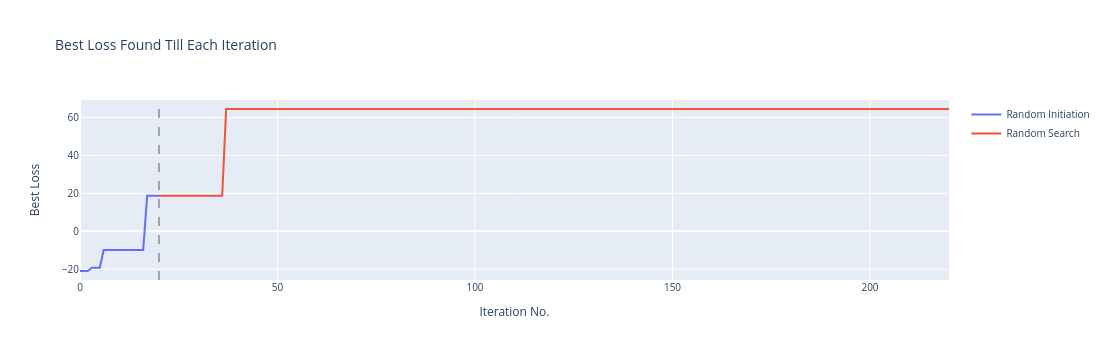

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set+1), y=optimizer.history['Y'][:init_set+1], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set, len(optimizer.history['Y'])), y=optimizer.history['Y'][init_set:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Best Loss",
    title="Best Loss Found Till Each Iteration",
    font=dict(size=10)
)
fig.add_vline(x=init_set, line_width=2, line_dash="dash", line_color="black", opacity=0.3)

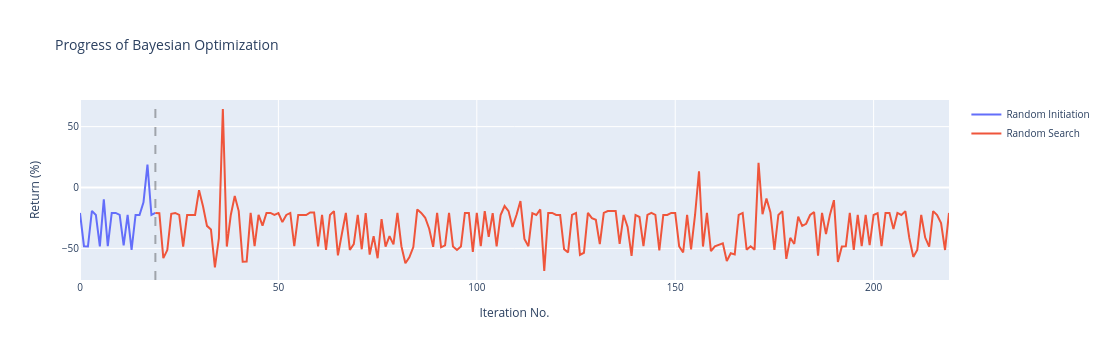

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0, init_set), y=optimizer.Y.flatten()[:init_set], mode='lines', name='Random Initiation'))
fig.add_trace(go.Scatter(x=np.arange(init_set-1, optimizer.Y.flatten().shape[-1]), y=optimizer.Y.flatten()[init_set-1:], mode='lines', name=optimizer.optimizer_name))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Return (%)",
    title="Progress of Bayesian Optimization",
    font=dict(size=10),
)

fig.add_vline(x=init_set - 1, line_width=2, line_dash="dash", line_color="black", opacity=0.3)

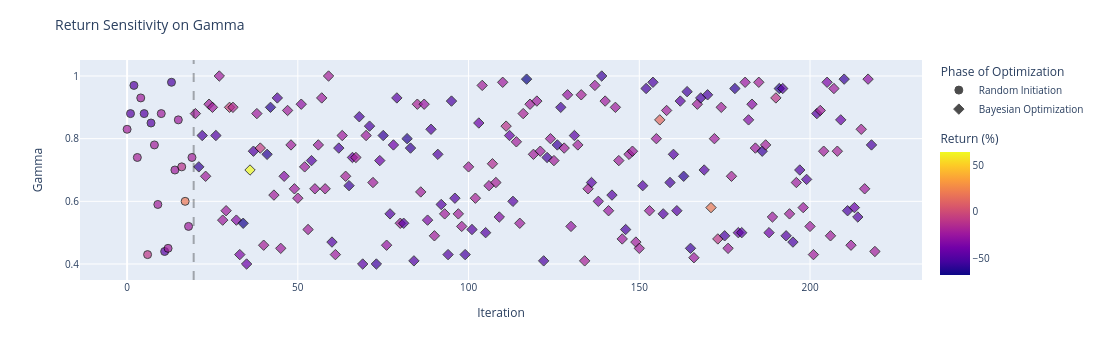

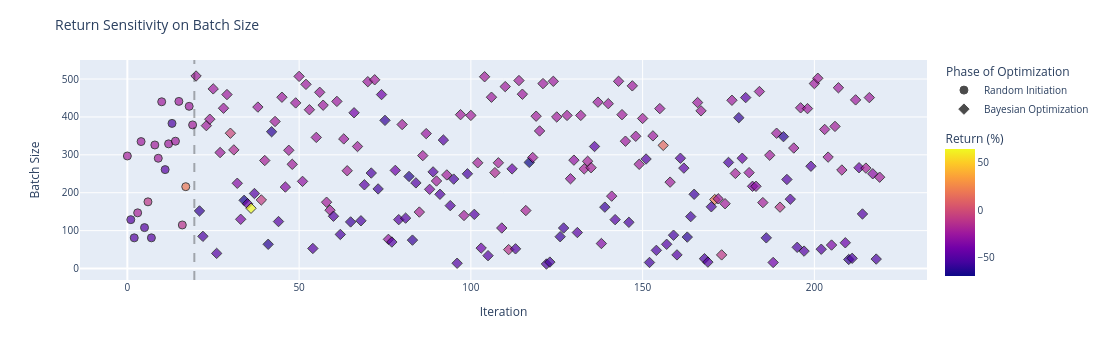

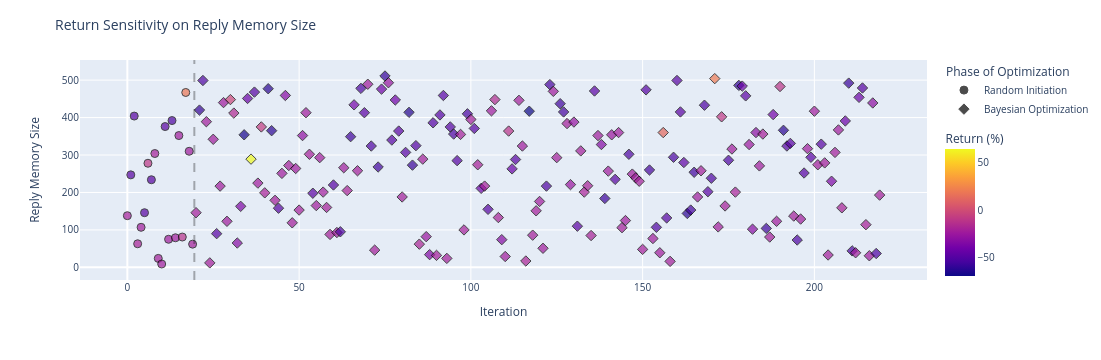

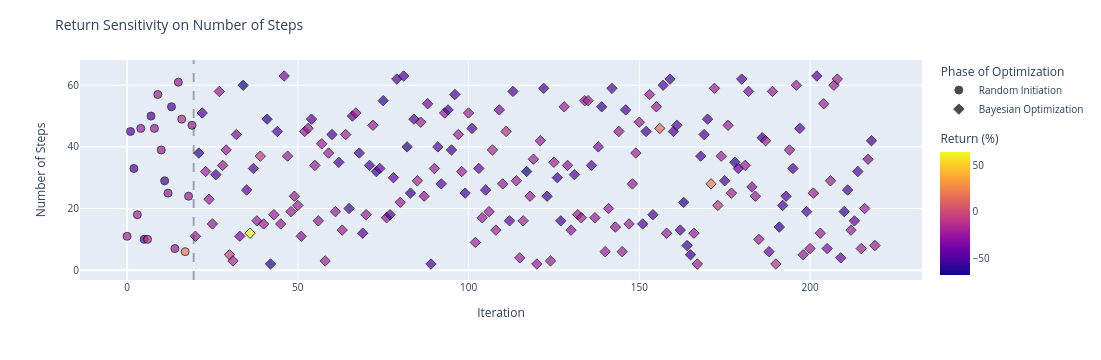

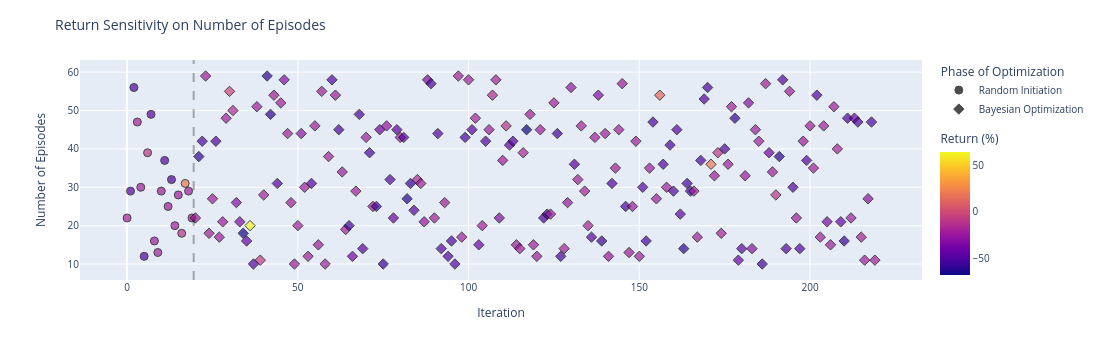

In [16]:
import numpy as np
import plotly.express as px

params = ['Gamma', 'Batch Size', 'Reply Memory Size', 'Number of Steps', 'Number of Episodes']

for index, param in enumerate(params):
    # Your existing data
    x = np.arange(len(optimizer.Y.flatten()))
    y = optimizer.X[:, index]
    returns = optimizer.Y.flatten()
    
    # Map labels to symbols
    symbols = np.array(['Random Initiation' if i < init_set else 'Bayesian Optimization' for i in range(len(x))])
    
    # Create the scatter plot with returns as color and symbols for 'Train' and 'Test'
    fig = px.scatter(
        x=x,
        y=y,
        color=returns,
        symbol=symbols,  # Use symbols here
        # labels={"x": "Iteration", "y": "Log2 of Batch Size"},
        # title="Return Sensitivity on Batch Size"
    )
    
    # Update plot layout
    fig.update_layout(title=f'Return Sensitivity on {param}',
        xaxis_title='Iteration',
        yaxis_title=f'{param}',
        legend_title="Phase of Optimization",
        font=dict(size=10))
    
    # Update trace properties
    fig.update_traces(marker=dict(
        size=8,
        opacity=0.7,
        line=dict(
            color='black',
            width=1
        )
    ))
    
    # Update color axis
    fig.update_layout(coloraxis_colorbar=dict(
        title="Return (%)",
        x=1.01,  # Adjust the position
        y=0.35,
        lenmode='fraction',
        len=0.75
    ))
    
    # Add annotations for 'Train' and 'Test'
    # fig.add_annotation(
    #     x=init_set - 0.15 * max(x) , y=max(y)*1.1, text="Random Initiation", showarrow=False, yshift=10
    # )
    # fig.add_annotation(
    #     x=init_set + 0.1 * max(x), y=max(y)*1.1, text="Bayesian Optimization", showarrow=False, yshift=10
    # )
    
    # Add a vertical line to separate 'Train' and 'Test'
    fig.add_vline(x=init_set - 0.5, line_width=2, line_dash="dash", line_color="black", opacity=0.3)
    
    # Show the plot
    fig.show()